# Supervised Loss: Train from scratch

**Goal:** Qualitatively, it seems like having the slot "know" about where the circle center and radius lives seems like a nice thing to have.

The warm start trainings weren't converging, so I'm going to try starting from scratch now!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.nn import init
import torch.nn.functional as F

# IO pkgs
import yaml, json
from glob import glob

# custom code
import os
os.sys.path.append('code')
from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from train import hungarian_matching
from model import SlotAttentionPosEmbed

%load_ext autoreload
%autoreload 2

### Step 1: Model 

Define a model architecture, and load in a "warm" starting point.

In [5]:
device='cuda:0'

In [6]:
cID_prev = 'learn-init-warm2'
with open(f'code/configs/{cID_prev}.yaml') as f:
    cd = yaml.safe_load(f)


hps = cd['hps']
hps['device'] = device
hps['learn_slot_feat'] = True

kwargs = cd['data']
kwargs['device'] = device
hps

{'hidden_dim': 16,
 'k_slots': 3,
 'query_dim': 128,
 'softmax_T': 'default',
 'learn_init': True,
 'device': 'cuda:0',
 'learn_slot_feat': True}

In [7]:
m = SlotAttentionPosEmbed(**hps).to(device)

Initialize the last layer of the network to match the means of the distribution.

In [9]:
m.final_mlp[2].bias

Parameter containing:
tensor([ 0.0281,  0.2314, -0.0988], device='cuda:0', requires_grad=True)

In [10]:
torch.nn.init.constant_(m.final_mlp[2].bias[:2],0)
torch.nn.init.constant_(m.final_mlp[2].bias[-1],0.17)

tensor(0.1700, device='cuda:0', grad_fn=<AsStridedBackward0>)

In [11]:
m.final_mlp[2].bias #= torch.Tensor([0,0,.17])

Parameter containing:
tensor([0.0000, 0.0000, 0.1700], device='cuda:0', requires_grad=True)

In [12]:
cID = 'li-Q128-sup-alpha1'

modelDir = f'code/models/{cID}'
figDir = f'code/figures/{cID}'

# for d in [modelDir,figDir]:
#     os.mkdir(d)

In [13]:
bs = 100
X, Y, mask = make_batch(N_events=bs, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [14]:
queries, att, Y_pred = m(X)

In [15]:
k_slots = 3
max_n_rings = 2
resolution = (32,32)

In [16]:
mask.shape

torch.Size([100, 2, 32, 32])

In [17]:
def comb_loss(att,flat_mask,Y=None,Y_pred=None,alpha=1):
    '''
    Goal: Given a NN that predicts both an occupancy mask
    and a center and radius for each slot, combine these terms 
    into a combined loss function:
    
    L = L_bce + alpha * L_mse
    
    Note: This function should be general enough to either calculate
    the losses of all the combinations of slots and targets or just
    the single loss between the loss and the chosen target
        
    '''
    
    att_ext  = torch.tile(att.unsqueeze(2), dims=(1,1,max_n_rings,1)) 
    mask_ext = torch.tile(flat_mask.unsqueeze(1),dims=(1,k_slots,1,1)) 
    
    l_bce = F.binary_cross_entropy(att_ext,mask_ext,reduction='none').mean(axis=-1)
    
    if alpha == 0:
        return l_bce
    
    else:
    
        # Calc MSEmse_loss(Y,Y_pred)
        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred.unsqueeze(2), Y.unsqueeze(1)).mean(axis=-1)
        return l_bce + alpha * l_mse
    

In [18]:
flat_mask = torch.reshape(mask,(bs, max_n_rings, np.prod(resolution)))

pairwise_cost = comb_loss(att, flat_mask,Y,Y_pred)
with torch.no_grad():
    indices = hungarian_matching(pairwise_cost)
    
pairwise_cost.shape

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100, 1, 2, 3])) that is different to the input size (torch.Size([100, 3, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([100, 3, 2])

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle

def plot_chosen_slots(losses, mask, att_img, Y_true, Y_pred, color='C0',cmap='Blues',figname=''):
    n_rings = att_img.shape[0]
    fig, axs = plt.subplots(1,n_rings+2,figsize=(3*(n_rings + 2) ,2.5))

    for k,v in losses.items():
        axs[0].plot(v,label=k)
    axs[0].set_xlabel('Iters')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    imgs   = [mask] + [att_img[i] for i in range(n_rings)]
    titles = ['Target']+[f'Slot {i}' for i in range(n_rings)]
    extent = [-0.5, 0.5]*2
    for i, (ax,img,title) in enumerate(zip(axs[1:],imgs, titles)):
        
        im = ax.imshow(img.detach().cpu().numpy(),cmap=cmap,
                       extent=extent,origin='lower') #,vmin=0,vmax=1)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax.set_title(title)
        

    # Add on the target image
    axi = axs[1]
    c_true = 'r'
    c_pred = 'k'
    for yi in Y_true.cpu().numpy():
    
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
    
    for axi,yi,oi in zip(axs[2:],Y_true.cpu().numpy(),Y_pred.detach().cpu().numpy()):
        
        axi.scatter(*yi[:2],marker='x',color=c_true)
        circle = Circle(yi[:2],yi[2],fill=False,color=c_true)
        axi.add_patch(circle)
        
        axi.scatter(*oi[:2],marker='x',color=c_pred)
        circle = Circle(oi[:2],oi[2],fill=False,color=c_pred)
        axi.add_patch(circle)

        axi.set_xlim(-0.5,0.5)
        axi.set_ylim(-0.5,0.5)
        
    if figname:
        plt.savefig(figname)

    plt.show()
    plt.close()

In [20]:
def train(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          alpha=1,
          losses = {'tot':[],'bce':[],'mse':[]},
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    train -- arguments copied from Lukas's fct (see train.py)
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    
    model.train()
    
    k_slots = model.k_slots
    max_n_rings = kwargs['N_clusters']
    resolution = model.resolution
    kwargs['device'] = device

    start = len(losses['tot'])
    for i in range(start,start+Ntrain):

        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        queries, att, Y_pred = model(X)
            
        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
        with torch.no_grad():
            
            pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
            indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        '''
        BCE loss
        '''
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

        '''
        MSE loss
        '''
        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()
    
        # Calculate the loss
        li = l_bce + alpha*l_mse
        
        li.backward()
        opt.step()
        opt.zero_grad()

        losses['tot'].append(float(li))
        losses['bce'].append(float(l_bce))
        losses['mse'].append(float(l_mse))
        
        if i % plot_every == 0:
            print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])
            
            iEvt = 0
            att_sorted  = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
            
            att_img = att_sorted[iEvt].reshape(max_n_rings,*resolution)

            plot_chosen_slots(losses,mask[iEvt].sum(axis=0), att_img,
                              Y_true_sorted[iEvt],Y_pred_sorted[iEvt])
            
        if (i % save_every == 0) and modelDir:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)

    model.eval()
    return model,losses

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([256, 1, 2, 3])) that is different to the input size (torch.Size([256, 3, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter 0 , loss 0.8057916 , lr 0.0


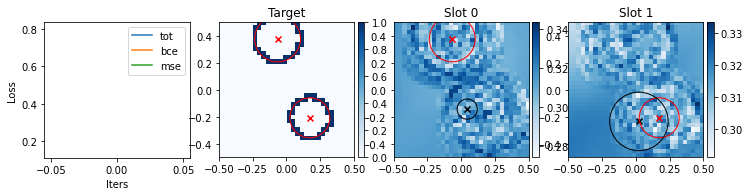

iter 100 , loss 0.8067286 , lr 5.999985195605575e-06


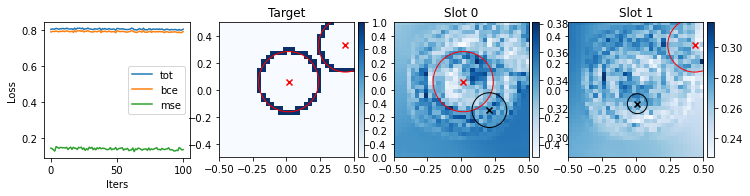

iter 200 , loss 0.78549206 , lr 1.1999881565136821e-05


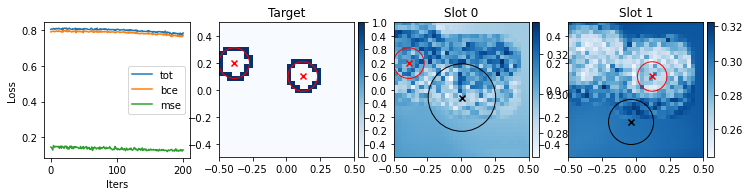

iter 300 , loss 0.7087445 , lr 1.7999600283980548e-05


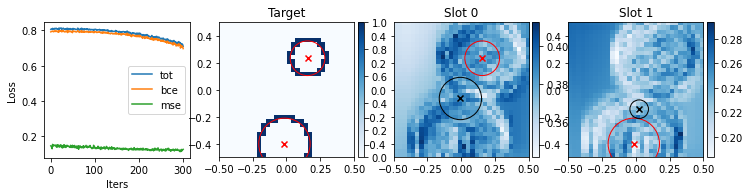

iter 400 , loss 0.6128668 , lr 2.399905253044579e-05


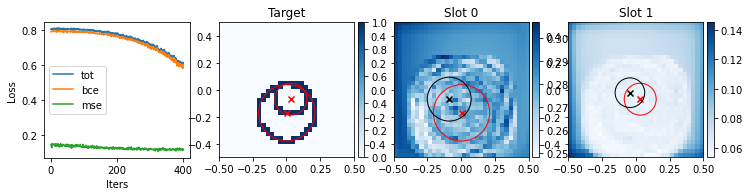

iter 500 , loss 0.48393673 , lr 2.999814948722491e-05


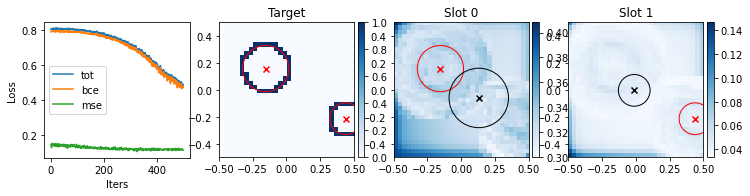

iter 600 , loss 0.39325875 , lr 3.5996802342854556e-05


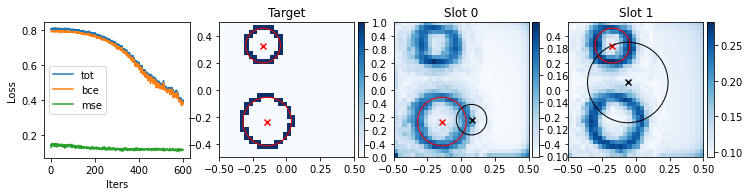

iter 700 , loss 0.26925388 , lr 4.1994922293176663e-05


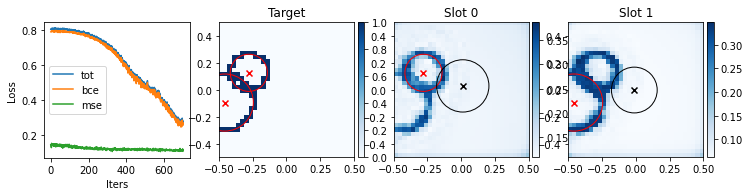

iter 800 , loss 0.19081959 , lr 4.79924205427992e-05


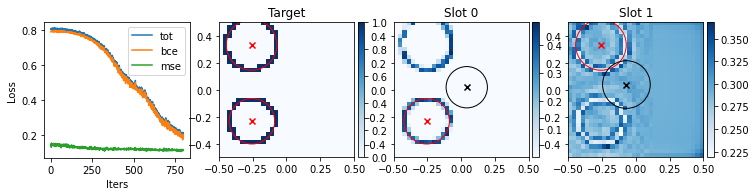

iter 900 , loss 0.14882648 , lr 5.3989208306556914e-05


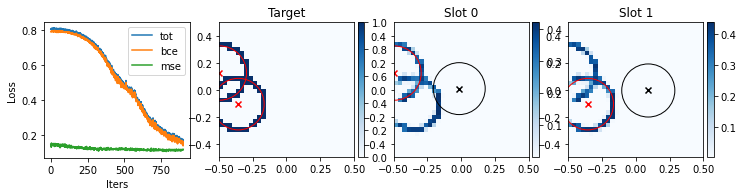

iter 1000 , loss 0.154805 , lr 5.998519681097195e-05


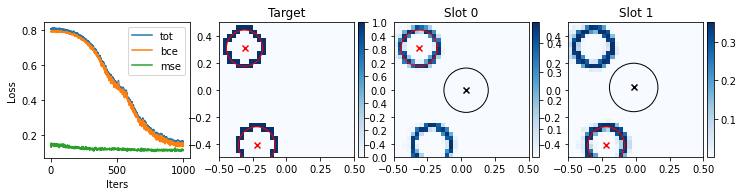

iter 1100 , loss 0.134471 , lr 6.59802972957141e-05


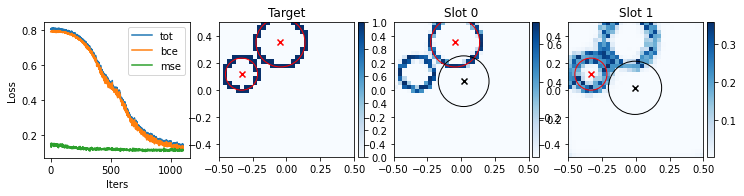

iter 1200 , loss 0.12753423 , lr 7.19744210150612e-05


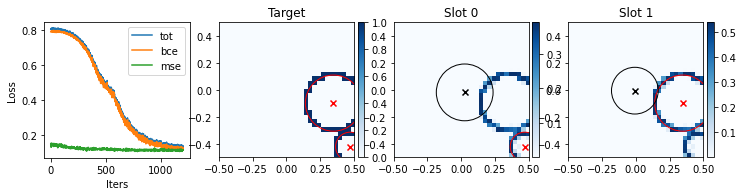

iter 1300 , loss 0.12458319 , lr 7.796747923935906e-05


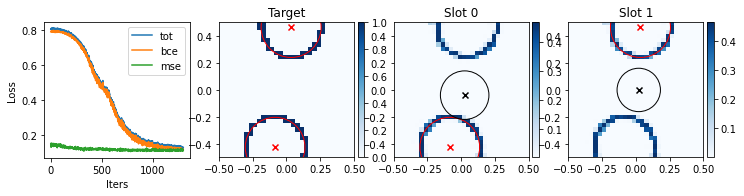

iter 1400 , loss 0.12357339 , lr 8.395938325648124e-05


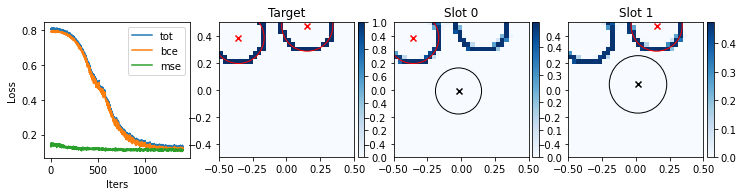

iter 1500 , loss 0.12584727 , lr 8.995004437328864e-05


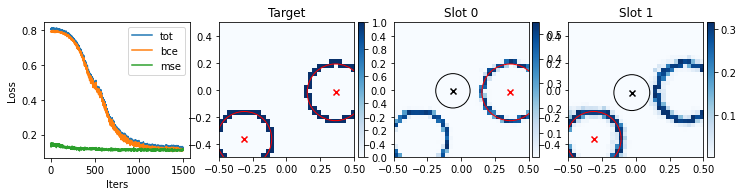

iter 1600 , loss 0.122628674 , lr 9.593937391708885e-05


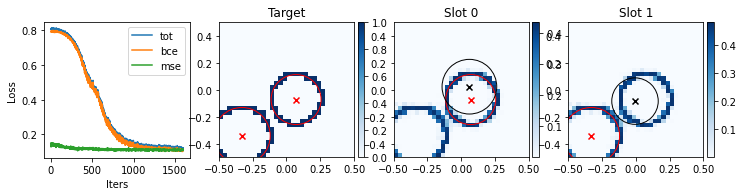

iter 1700 , loss 0.11695817 , lr 0.000101927283237095


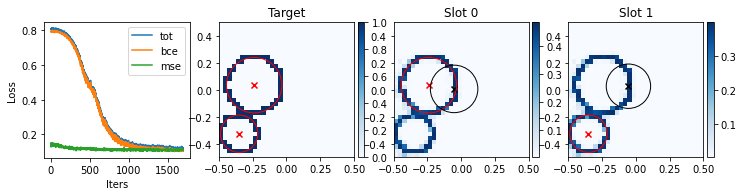

iter 1800 , loss 0.11822532 , lr 0.00010791368370588464


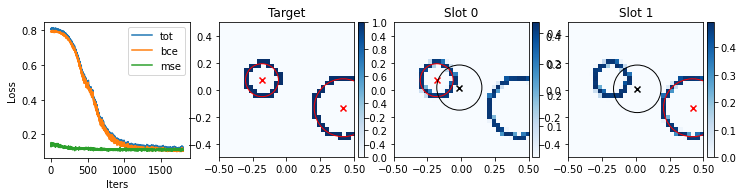

iter 1900 , loss 0.12092884 , lr 0.00011389848672085807


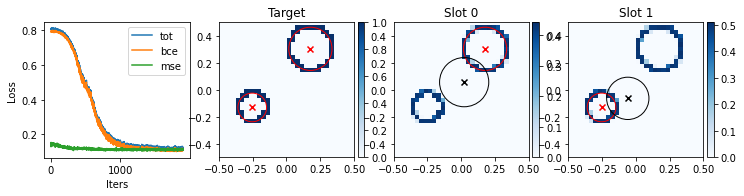

iter 2000 , loss 0.11509433 , lr 0.00011988160370569629


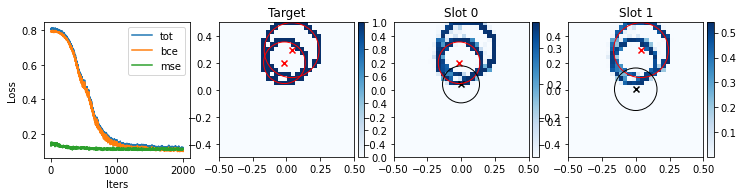

iter 2100 , loss 0.114510976 , lr 0.0001258629461118188


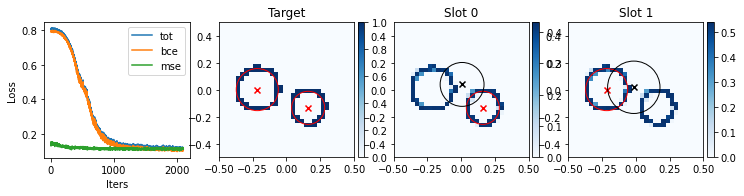

iter 2200 , loss 0.11438078 , lr 0.00013184242541984086


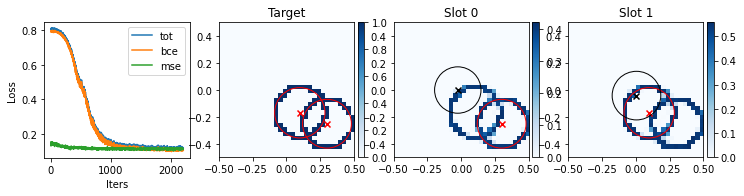

iter 2300 , loss 0.111025125 , lr 0.00013781995314103034


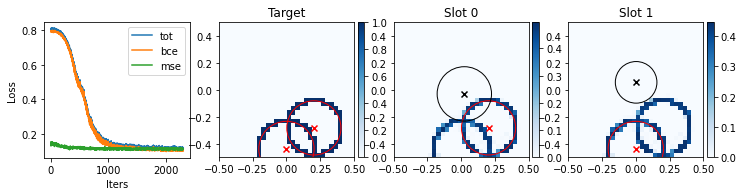

iter 2400 , loss 0.11838232 , lr 0.00014379544081876417


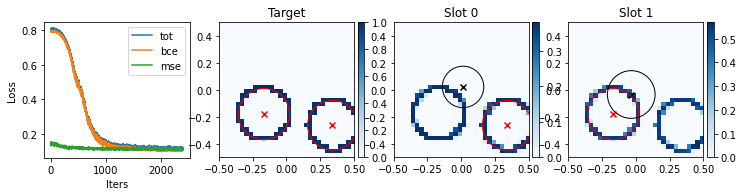

iter 2500 , loss 0.11516715 , lr 0.00014976880002998458


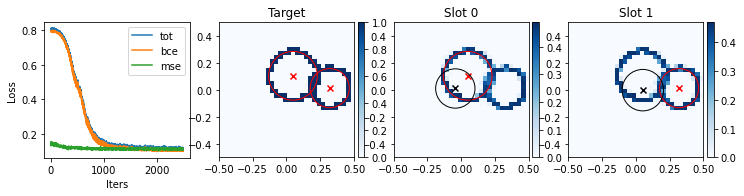

iter 2600 , loss 0.11433135 , lr 0.00015573994238665432


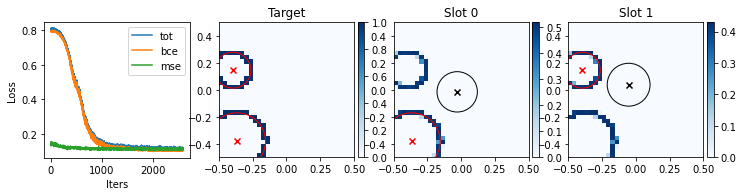

iter 2700 , loss 0.10815561 , lr 0.00016170877953721198


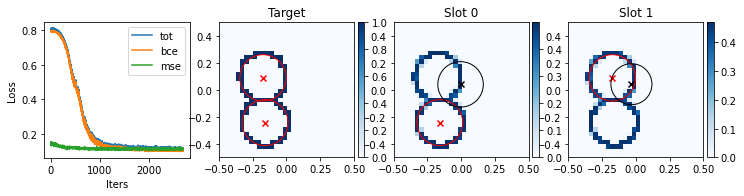

iter 2800 , loss 0.11501546 , lr 0.0001676752231680265


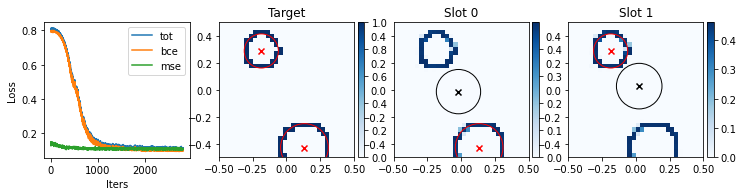

iter 2900 , loss 0.106929794 , lr 0.0001736391850048511


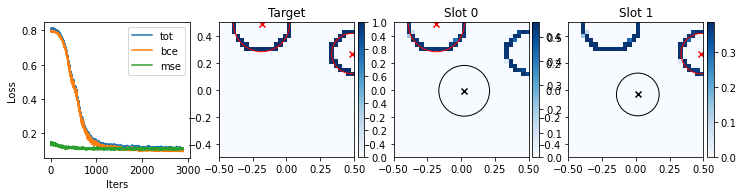

iter 3000 , loss 0.11794084 , lr 0.00017960057681427717


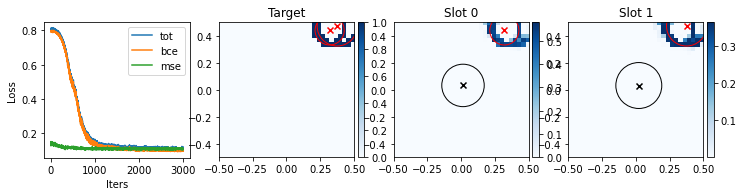

iter 3100 , loss 0.11069758 , lr 0.00018555931040518668


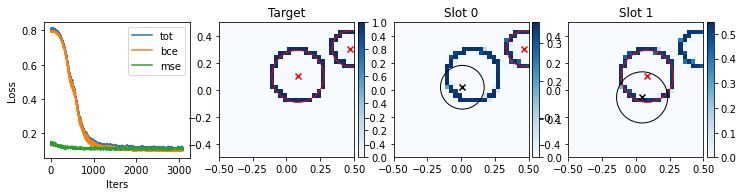

iter 3200 , loss 0.111651614 , lr 0.0001915152976302048


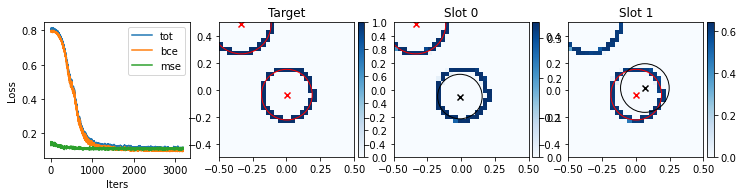

iter 3300 , loss 0.111977145 , lr 0.0001974684503871518


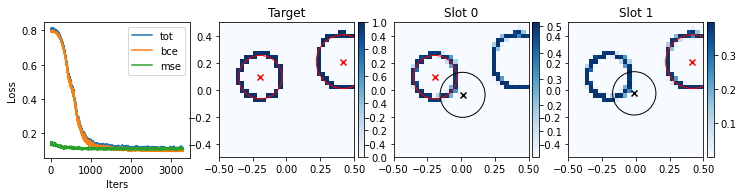

iter 3400 , loss 0.108308084 , lr 0.0002034186806204939


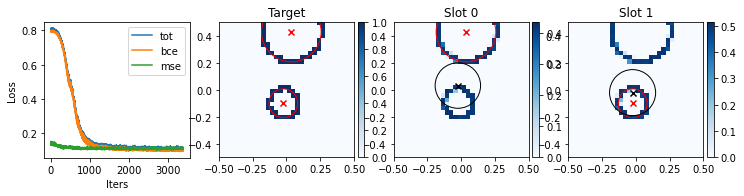

iter 3500 , loss 0.10594113 , lr 0.00020936590032279387


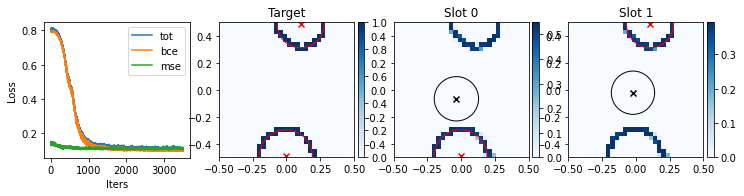

iter 3600 , loss 0.11224655 , lr 0.00021531002153616087


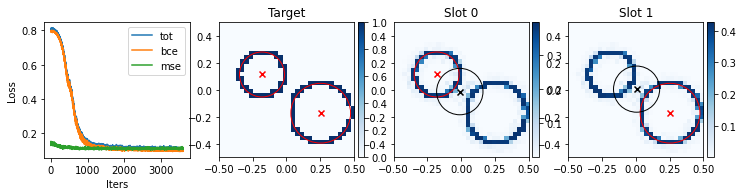

iter 3700 , loss 0.10707589 , lr 0.00022125095635369967


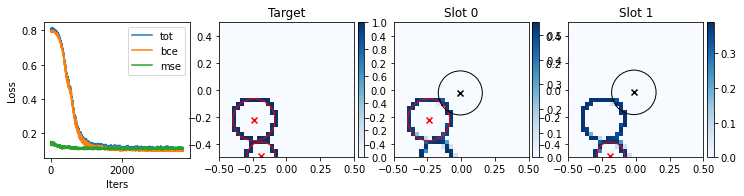

iter 3800 , loss 0.10982169 , lr 0.00022718861692095873


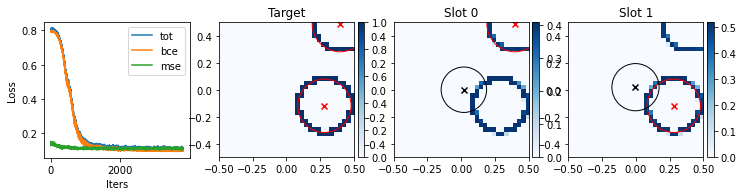

iter 3900 , loss 0.1146526 , lr 0.00023312291543737838


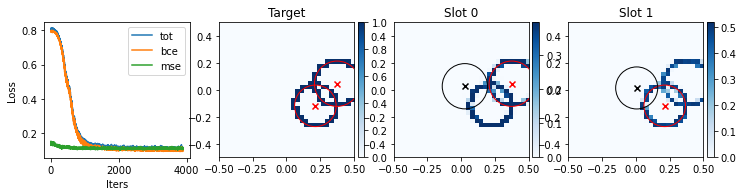

iter 4000 , loss 0.10895982 , lr 0.00023905376415773736


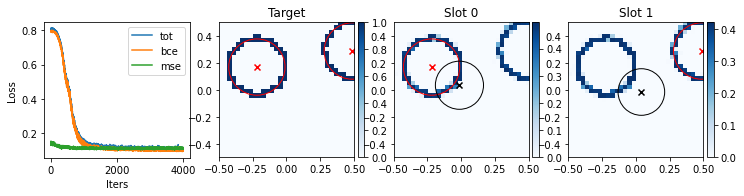

iter 4100 , loss 0.10728639 , lr 0.0002449810753935992


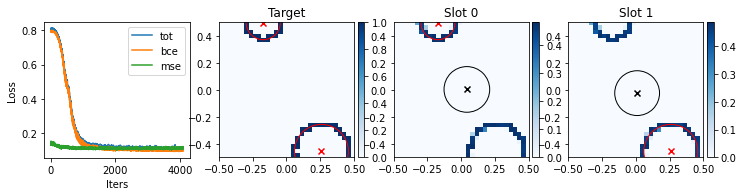

iter 4200 , loss 0.11128557 , lr 0.0002509047615147578


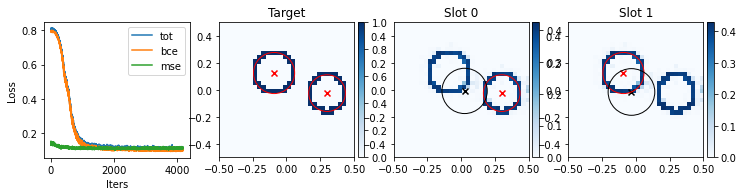

iter 4300 , loss 0.10811241 , lr 0.00025682473495068165


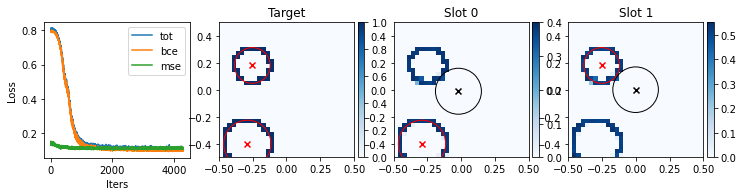

iter 4400 , loss 0.10434274 , lr 0.0002627409081919579


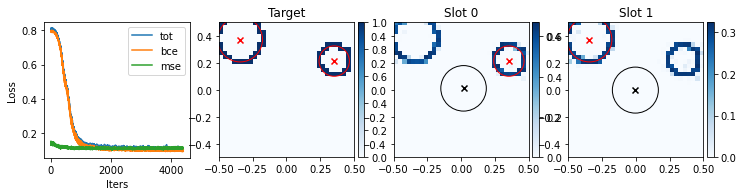

iter 4500 , loss 0.11064333 , lr 0.00026865319379173525


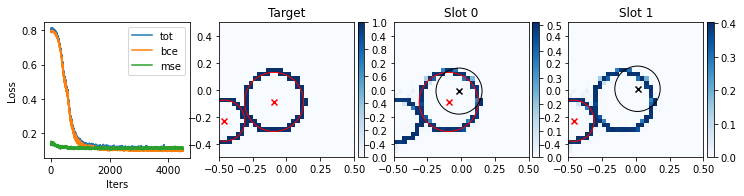

iter 4600 , loss 0.10831574 , lr 0.0002745615043671658


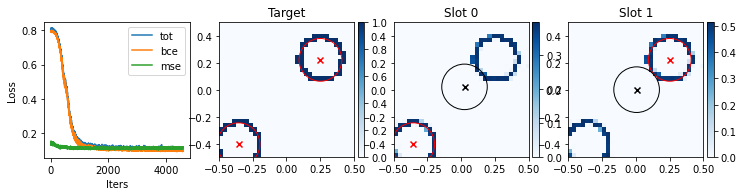

iter 4700 , loss 0.10407469 , lr 0.00028046575260084653


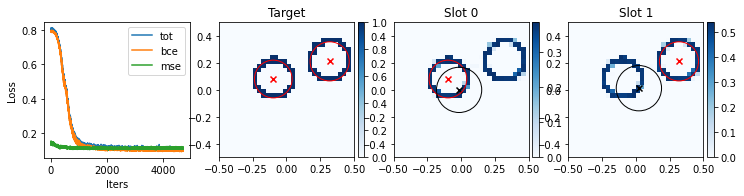

iter 4800 , loss 0.110797524 , lr 0.0002863658512422596


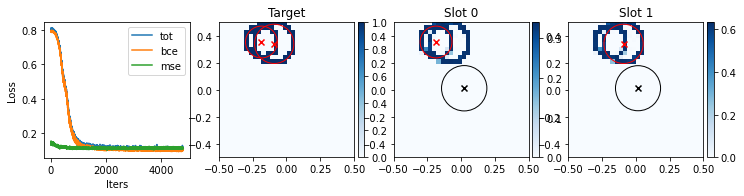

iter 4900 , loss 0.10986238 , lr 0.0002922617131092112


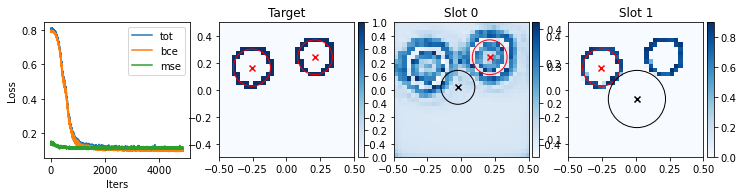

iter 5000 , loss 0.109598674 , lr 0.00029815325108927063


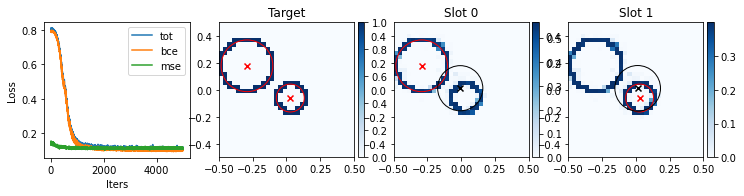

iter 5100 , loss 0.10896357 , lr 0.00029807880209922283


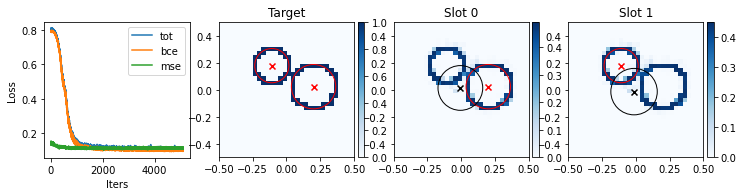

iter 5200 , loss 0.10907046 , lr 0.00029800289163118014


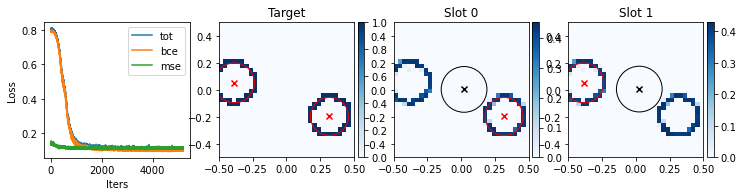

iter 5300 , loss 0.11017917 , lr 0.00029792552043434833


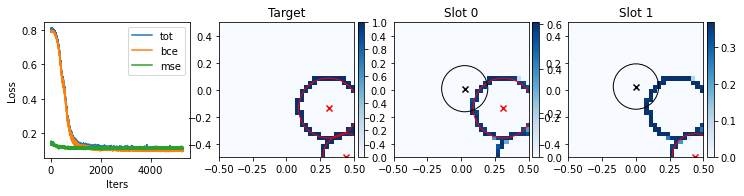

iter 5400 , loss 0.11019342 , lr 0.0002978466892723497


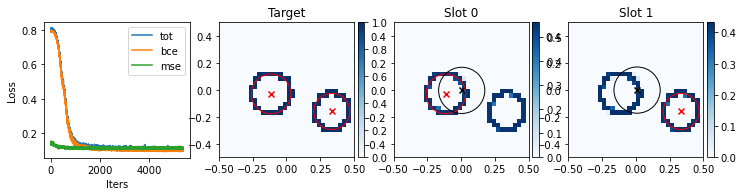

iter 5500 , loss 0.10369437 , lr 0.00029776639892321606


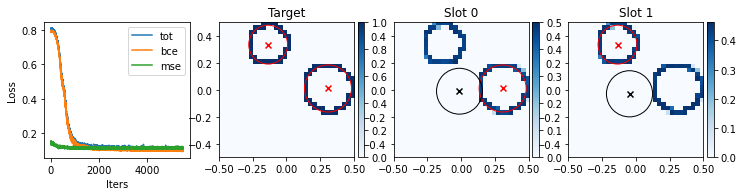

iter 5600 , loss 0.112468064 , lr 0.0002976846501793808


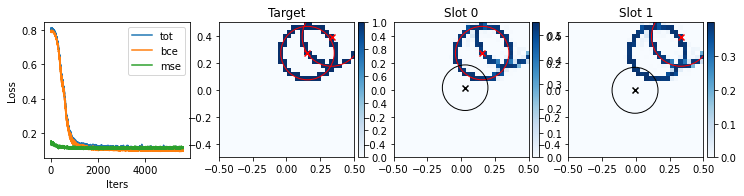

iter 5700 , loss 0.10692354 , lr 0.00029760144384767095


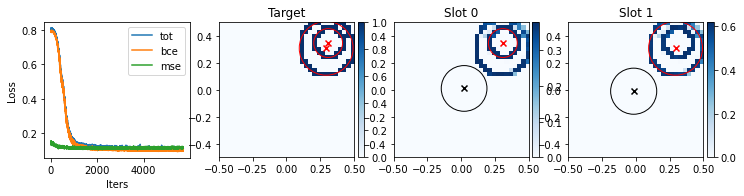

iter 5800 , loss 0.106859565 , lr 0.0002975167807492994


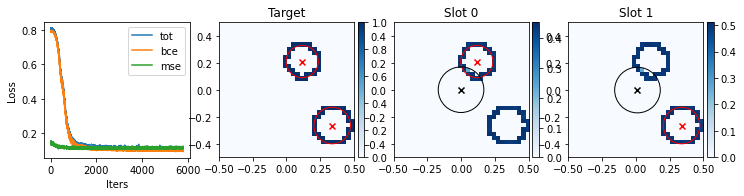

iter 5900 , loss 0.10857157 , lr 0.0002974306617198568


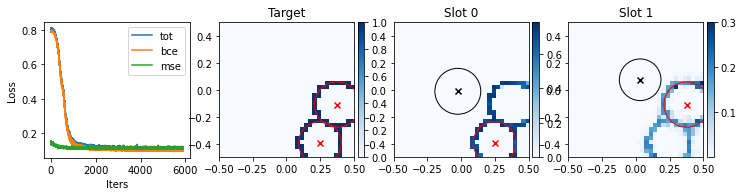

iter 6000 , loss 0.10301768 , lr 0.0002973430876093033


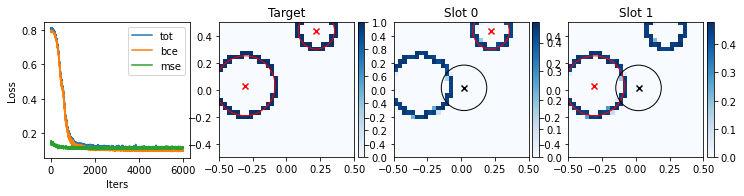

iter 6100 , loss 0.10814905 , lr 0.0002972540592819598


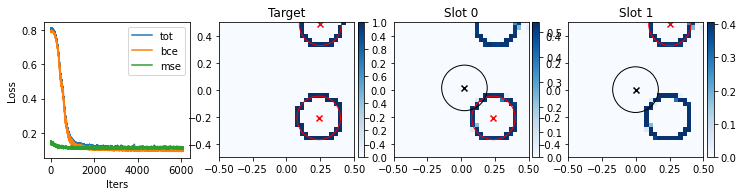

iter 6200 , loss 0.107618675 , lr 0.00029716357761650007


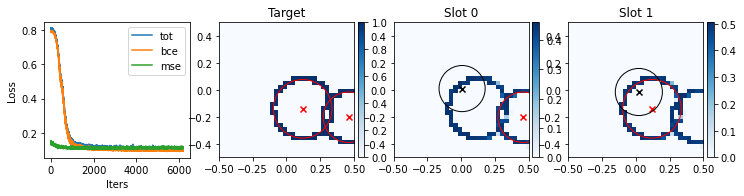

iter 6300 , loss 0.10643531 , lr 0.0002970716435059416


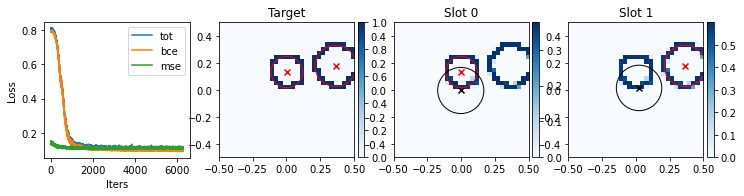

iter 6400 , loss 0.11083558 , lr 0.000296978257857637


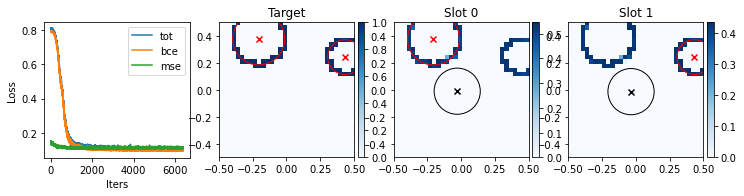

iter 6500 , loss 0.11907404 , lr 0.0002968834215932648


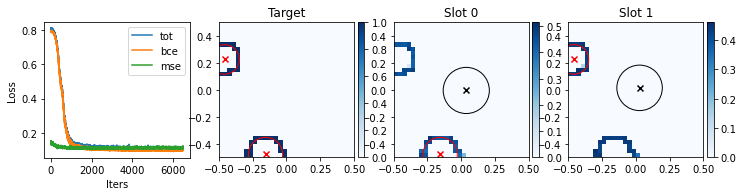

iter 6600 , loss 0.10865898 , lr 0.0002967871356488208


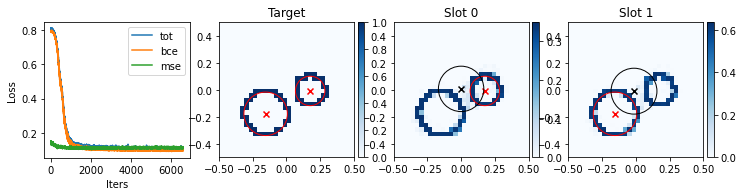

iter 6700 , loss 0.10370029 , lr 0.00029668940097460827


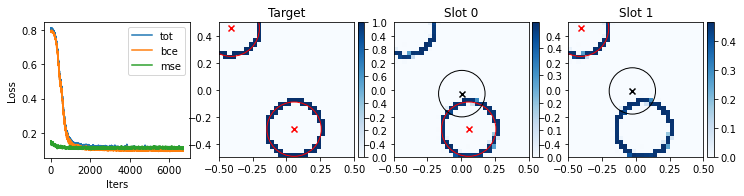

iter 6800 , loss 0.11382546 , lr 0.000296590218535229


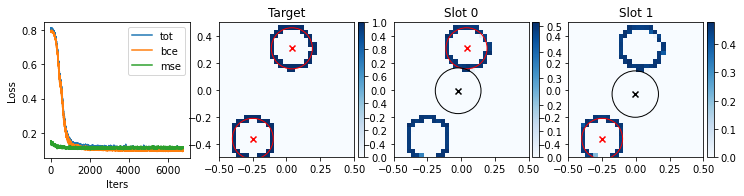

iter 6900 , loss 0.10398427 , lr 0.0002964895893095737


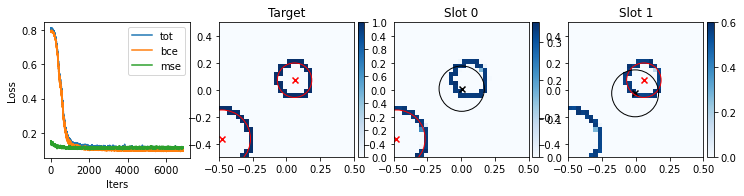

iter 7000 , loss 0.10611528 , lr 0.0002963875142908121


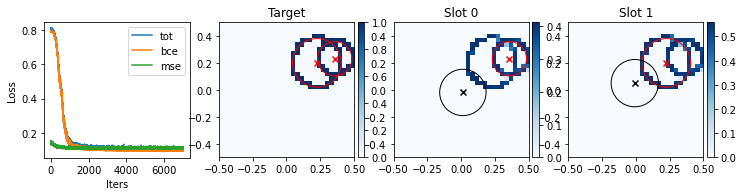

iter 7100 , loss 0.10576378 , lr 0.0002962839944863835


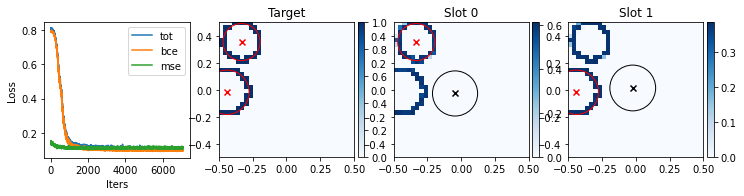

iter 7200 , loss 0.10591971 , lr 0.0002961790309179866


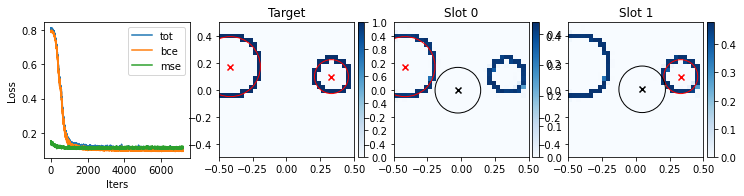

iter 7300 , loss 0.10578291 , lr 0.0002960726246215693


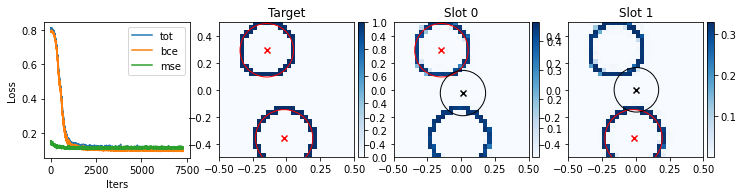

iter 7400 , loss 0.10379011 , lr 0.00029596477664731895


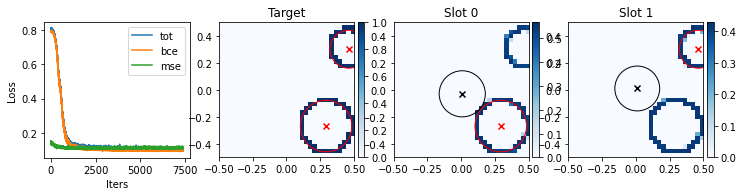

iter 7500 , loss 0.10200141 , lr 0.0002958554880596515


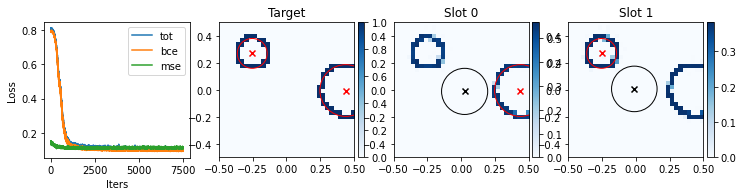

iter 7600 , loss 0.104494594 , lr 0.0002957447599372011


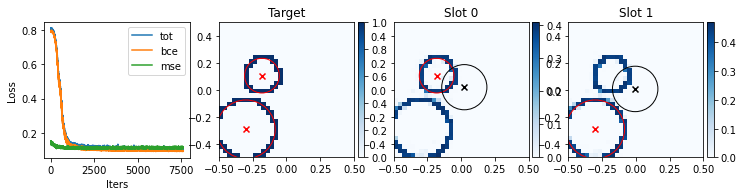

iter 7700 , loss 0.10324063 , lr 0.00029563259337280965


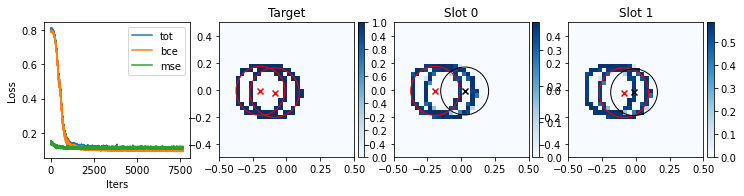

iter 7800 , loss 0.112113394 , lr 0.00029551898947351586


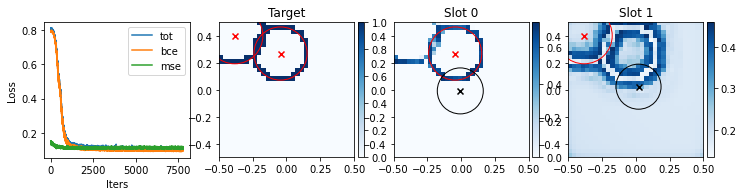

iter 7900 , loss 0.105908334 , lr 0.00029540394936054435


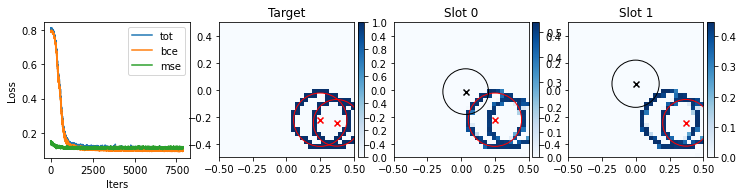

iter 8000 , loss 0.105621226 , lr 0.00029528747416929463


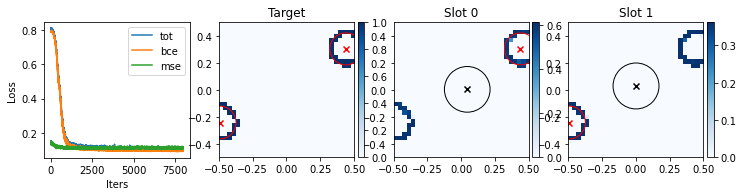

iter 8100 , loss 0.10480394 , lr 0.0002951695650493298


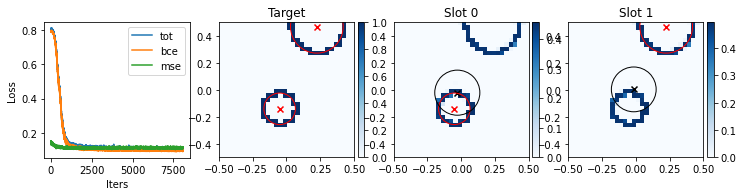

iter 8200 , loss 0.10465578 , lr 0.00029505022316436523


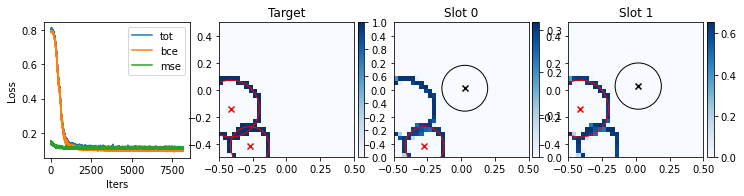

iter 8300 , loss 0.10523797 , lr 0.0002949294496922572


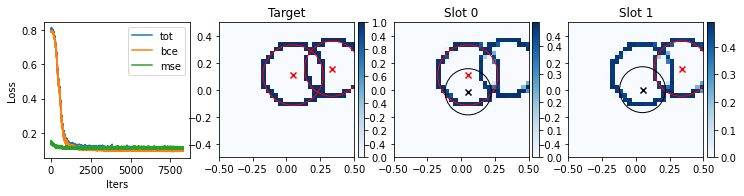

iter 8400 , loss 0.103650905 , lr 0.00029480724582499107


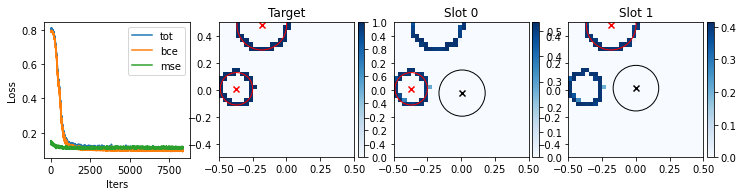

iter 8500 , loss 0.10520199 , lr 0.0002946836127686697


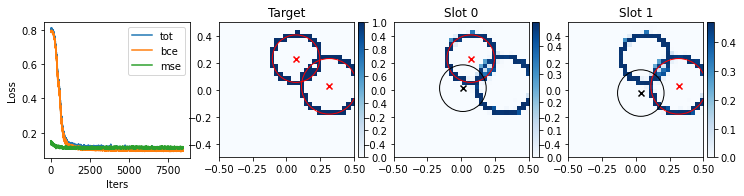

iter 8600 , loss 0.10925765 , lr 0.00029455855174350147


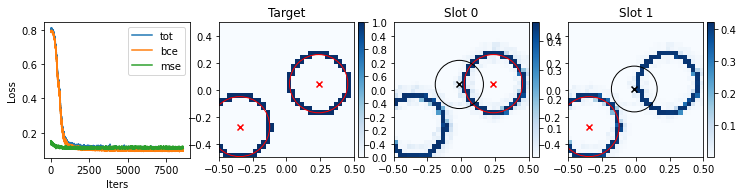

iter 8700 , loss 0.10763222 , lr 0.0002944320639837881


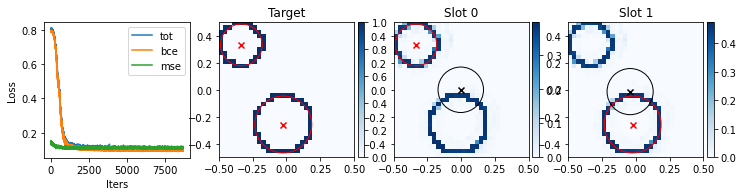

iter 8800 , loss 0.104968205 , lr 0.0002943041507379128


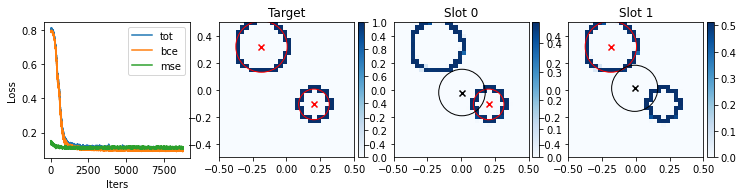

iter 8900 , loss 0.101481445 , lr 0.00029417481326832776


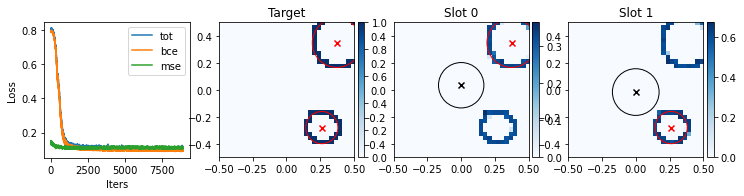

iter 9000 , loss 0.11136709 , lr 0.0002940440528515414


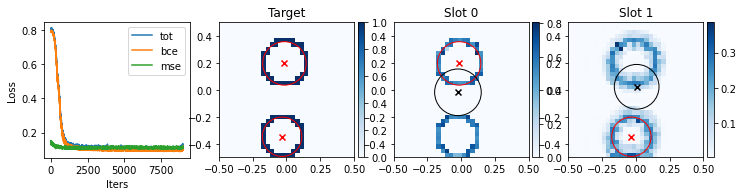

iter 9100 , loss 0.10232041 , lr 0.0002939118707781064


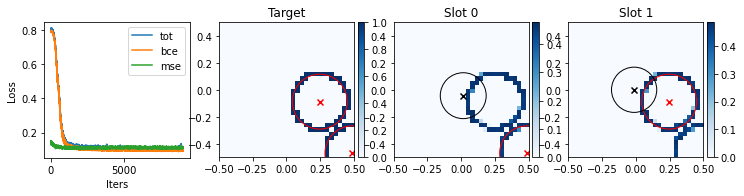

iter 9200 , loss 0.10461683 , lr 0.0002937782683526063


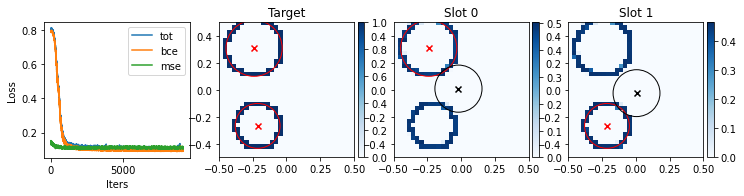

iter 9300 , loss 0.10273644 , lr 0.0002936432468936433


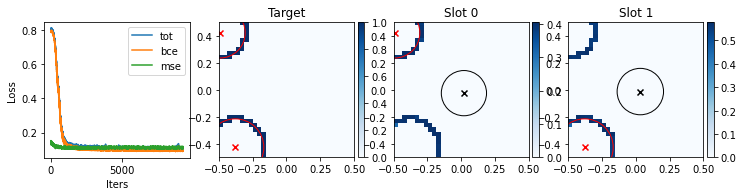

iter 9400 , loss 0.10344969 , lr 0.00029350680773382456


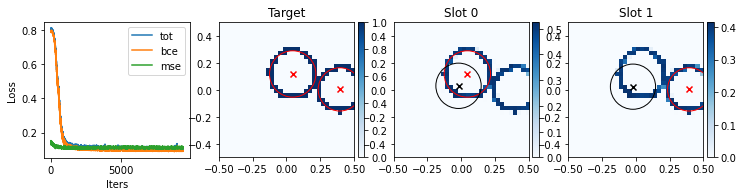

iter 9500 , loss 0.10703788 , lr 0.00029336895221974946


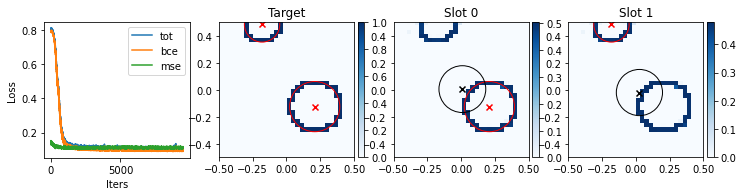

iter 9600 , loss 0.105207205 , lr 0.0002932296817119964


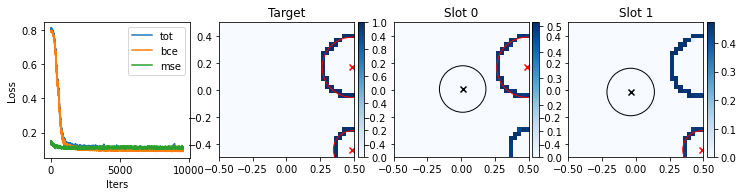

iter 9700 , loss 0.106614634 , lr 0.000293088997585109


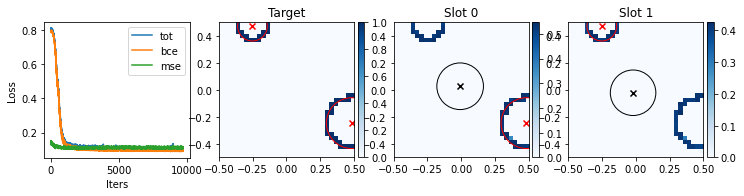

iter 9800 , loss 0.1053685 , lr 0.00029294690122758283


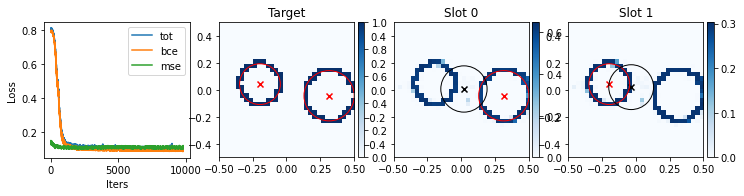

iter 9900 , loss 0.10748426 , lr 0.00029280339404185146


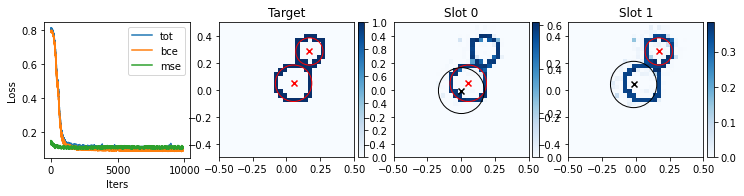

iter 10000 , loss 0.104792826 , lr 0.00029265847744427303


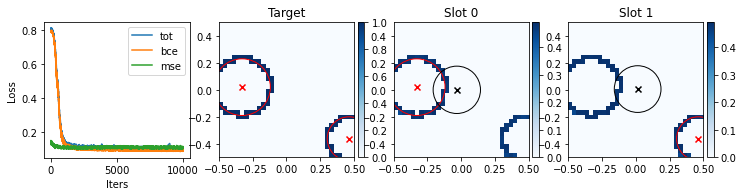

iter 10100 , loss 0.10241144 , lr 0.00029251215286511573


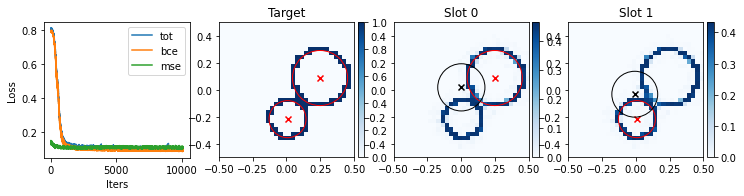

iter 10200 , loss 0.104967356 , lr 0.00029236442174854416


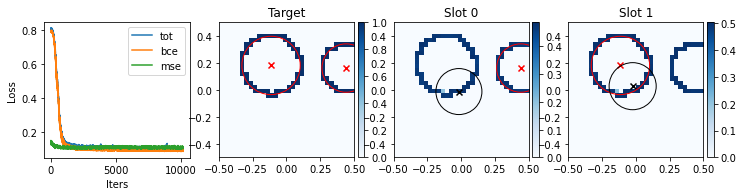

iter 10300 , loss 0.10199869 , lr 0.00029221528555260475


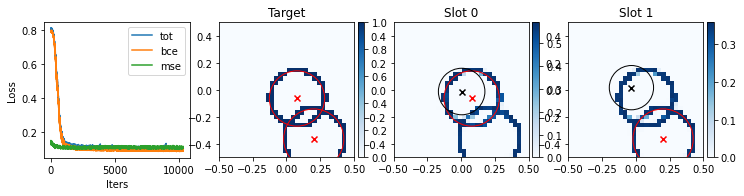

iter 10400 , loss 0.10024466 , lr 0.00029206474574921165


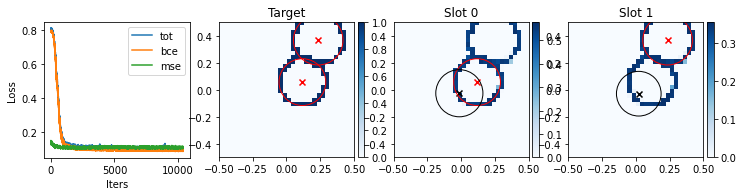

iter 10500 , loss 0.102911115 , lr 0.0002919128038241318


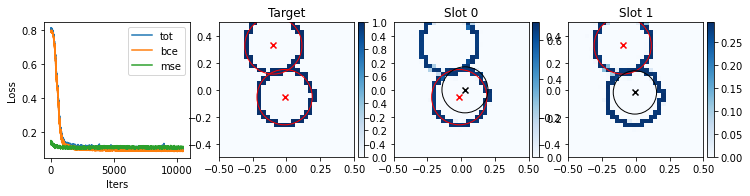

iter 10600 , loss 0.10334537 , lr 0.0002917594612769707


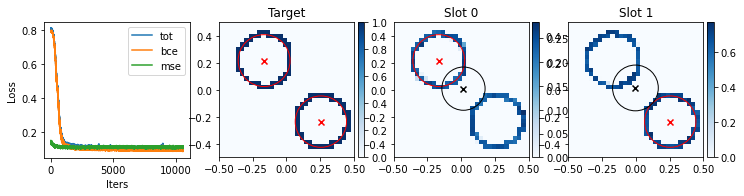

iter 10700 , loss 0.10018761 , lr 0.00029160471962115747


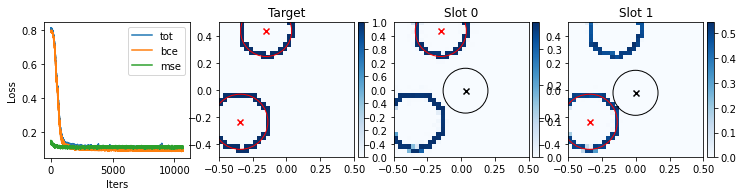

iter 10800 , loss 0.108162716 , lr 0.00029144858038392964


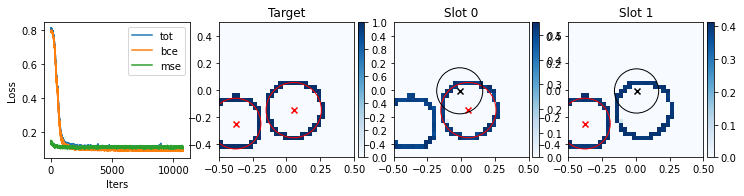

iter 10900 , loss 0.103214085 , lr 0.00029129104510631853


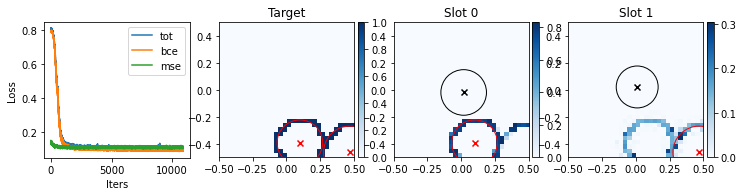

iter 11000 , loss 0.10203776 , lr 0.0002911321153431338


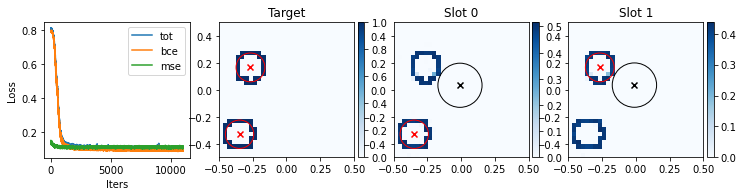

iter 11100 , loss 0.10318184 , lr 0.0002909717926629479


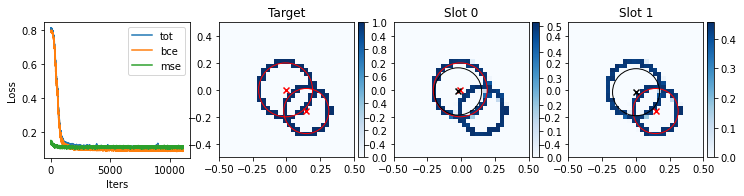

iter 11200 , loss 0.10075165 , lr 0.0002908100786480811


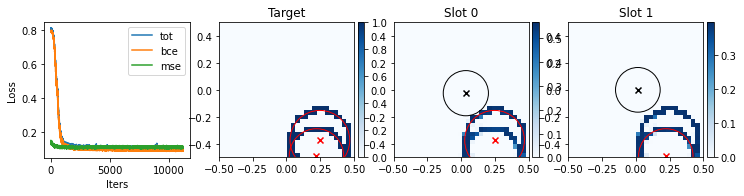

iter 11300 , loss 0.10101907 , lr 0.0002906469748945853


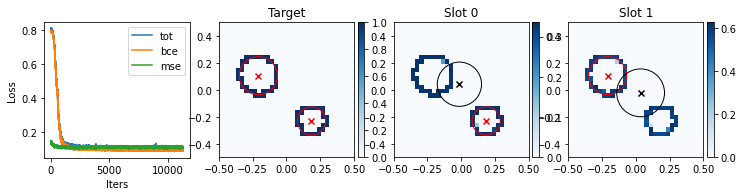

iter 11400 , loss 0.107439704 , lr 0.00029048248301222885


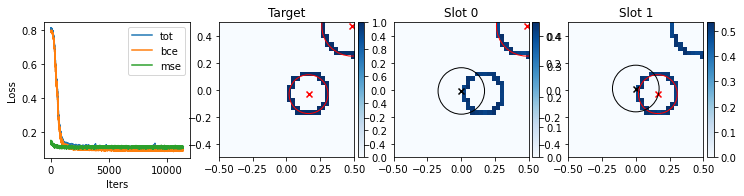

iter 11500 , loss 0.10482685 , lr 0.0002903166046244801


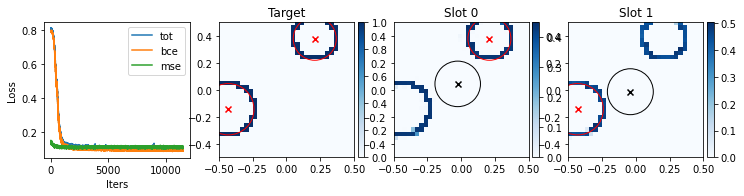

iter 11600 , loss 0.103046134 , lr 0.0002901493413684918


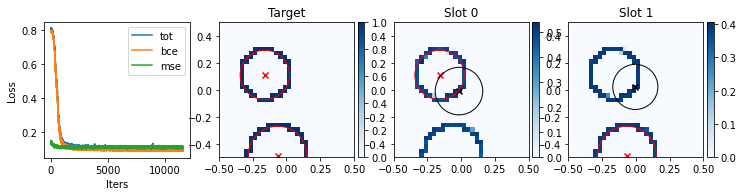

iter 11700 , loss 0.1053817 , lr 0.00028998069489508474


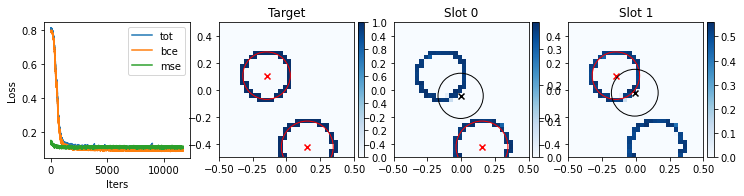

iter 11800 , loss 0.10320852 , lr 0.0002898106668687316


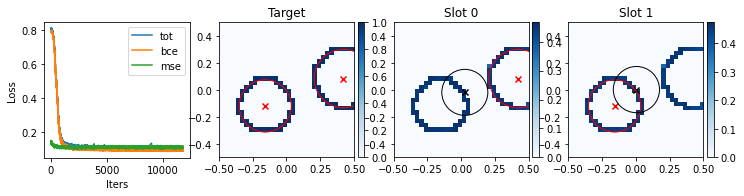

iter 11900 , loss 0.10532857 , lr 0.00028963925896754035


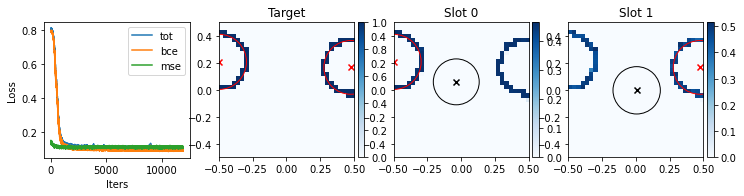

iter 12000 , loss 0.102029204 , lr 0.00028946647288323766


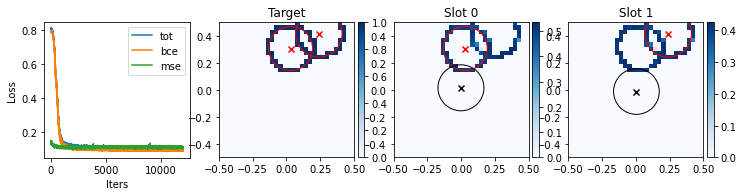

iter 12100 , loss 0.10373856 , lr 0.0002892923103211526


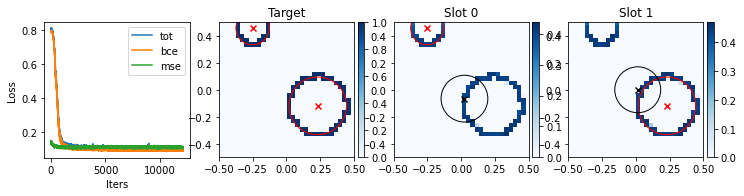

iter 12200 , loss 0.10615524 , lr 0.0002891167730001992


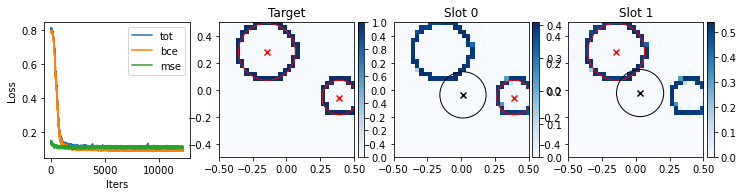

iter 12300 , loss 0.10060458 , lr 0.00028893986265286


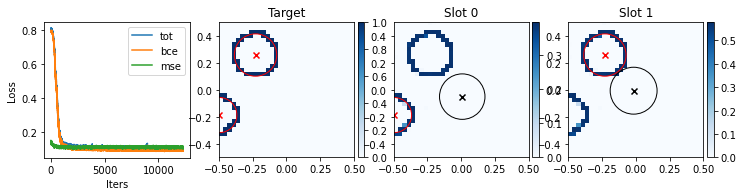

iter 12400 , loss 0.100612335 , lr 0.0002887615810251687


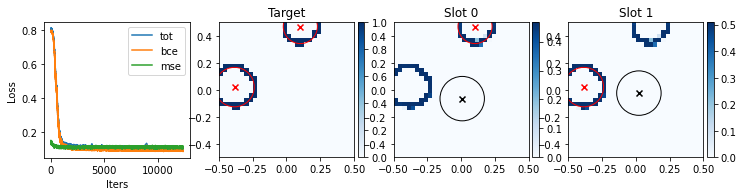

iter 12500 , loss 0.102696784 , lr 0.000288581929876693


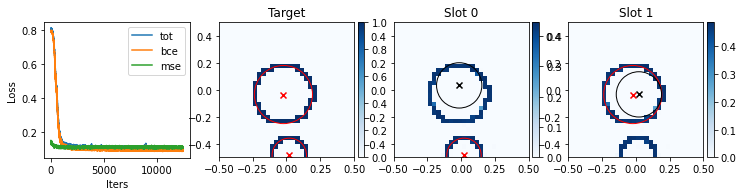

iter 12600 , loss 0.10315941 , lr 0.0002884009109805172


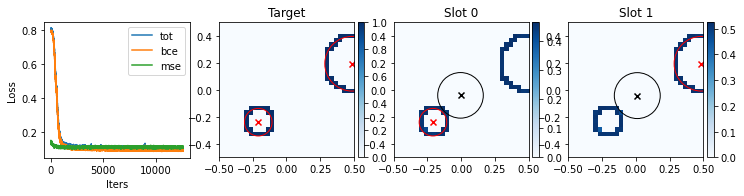

iter 12700 , loss 0.10358241 , lr 0.00028821852612322476


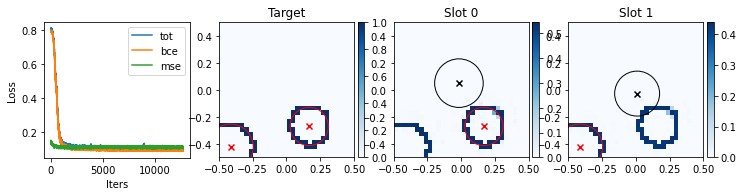

iter 12800 , loss 0.101296075 , lr 0.00028803477710488055


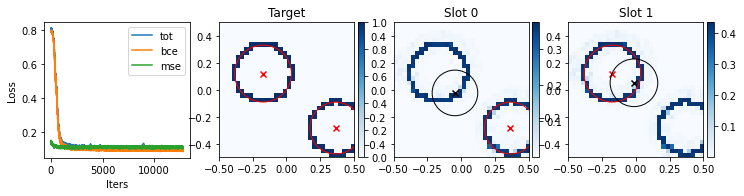

iter 12900 , loss 0.10184906 , lr 0.00028784966573901314


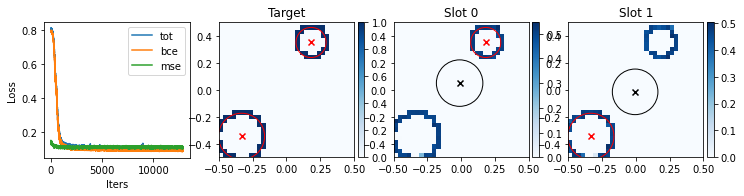

iter 13000 , loss 0.10583222 , lr 0.00028766319385259713


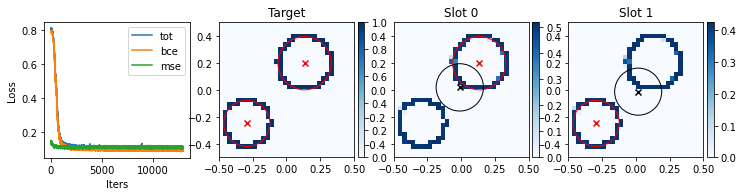

iter 13100 , loss 0.10014064 , lr 0.0002874753632860347


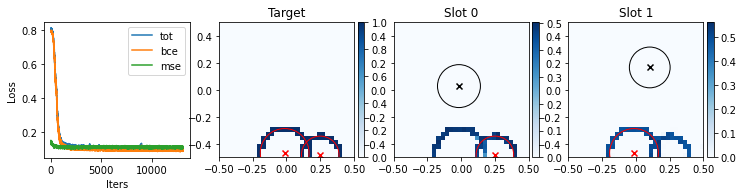

iter 13200 , loss 0.09975254 , lr 0.0002872861758931376


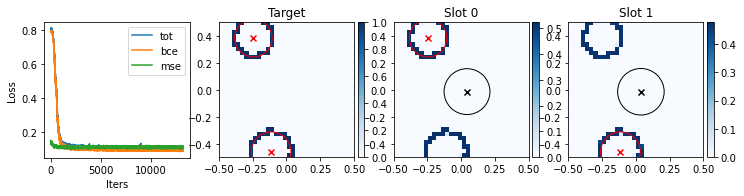

iter 13300 , loss 0.10051851 , lr 0.00028709563354110913


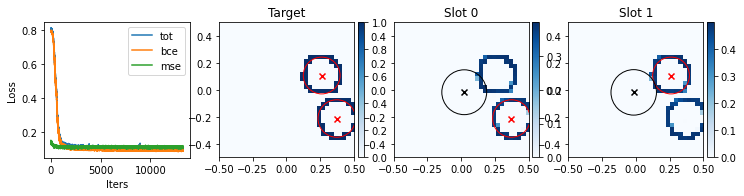

iter 13400 , loss 0.10257663 , lr 0.0002869037381105254


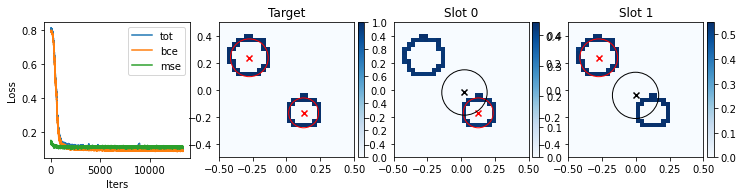

iter 13500 , loss 0.1045769 , lr 0.00028671049149531675


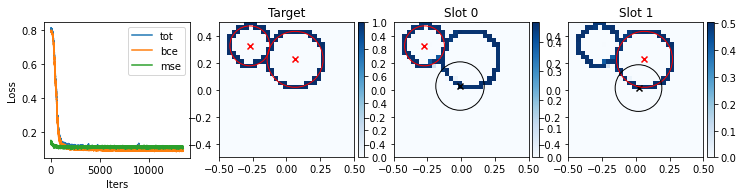

iter 13600 , loss 0.10370032 , lr 0.00028651589560274934


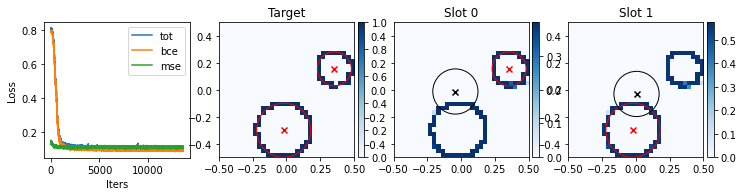

iter 13700 , loss 0.10230572 , lr 0.00028631995235340604


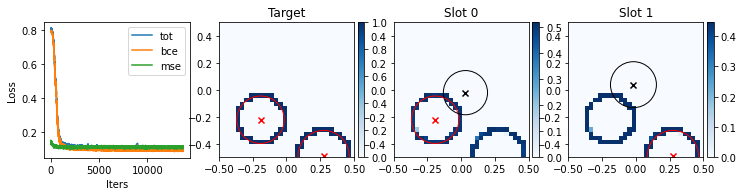

iter 13800 , loss 0.10354878 , lr 0.0002861226636811675


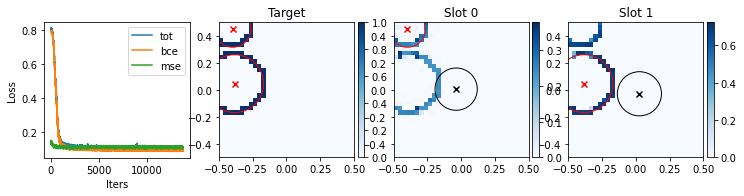

iter 13900 , loss 0.10137746 , lr 0.00028592403153319344


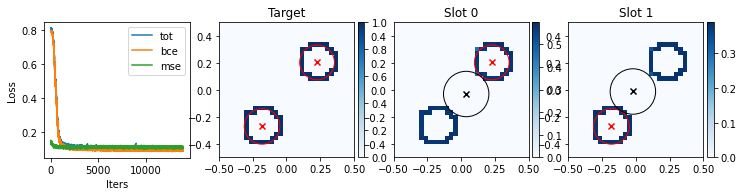

iter 14000 , loss 0.104253955 , lr 0.00028572405786990294


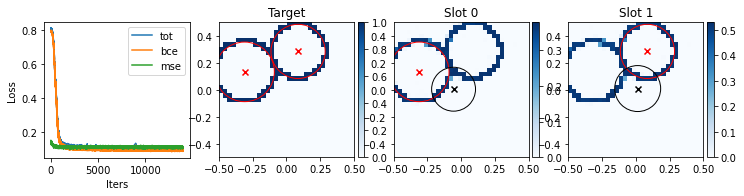

iter 14100 , loss 0.0998027 , lr 0.0002855227446649552


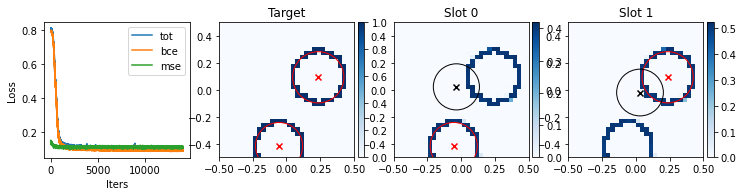

iter 14200 , loss 0.10171784 , lr 0.00028532009390523037


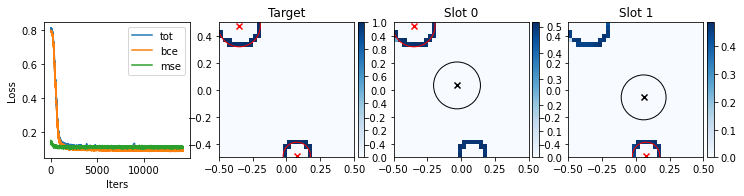

iter 14300 , loss 0.09880743 , lr 0.00028511610759080966


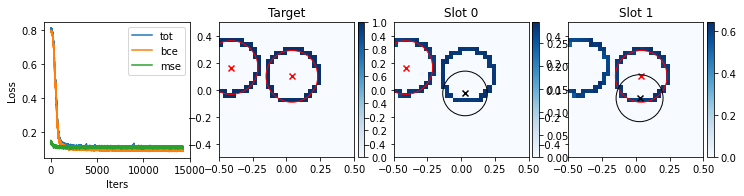

iter 14400 , loss 0.10019643 , lr 0.00028491078773495564


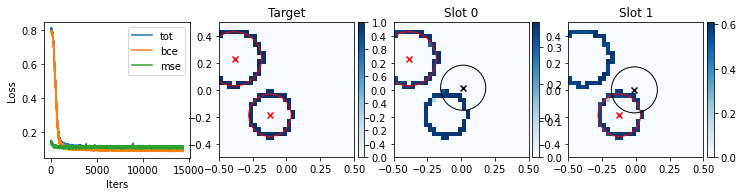

iter 14500 , loss 0.10080085 , lr 0.0002847041363640923


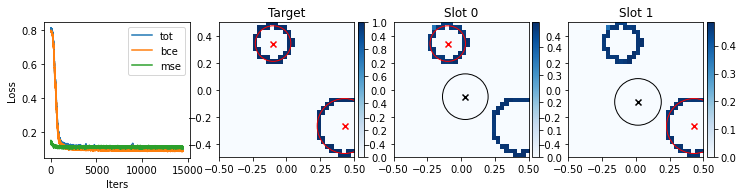

iter 14600 , loss 0.09951196 , lr 0.00028449615551778536


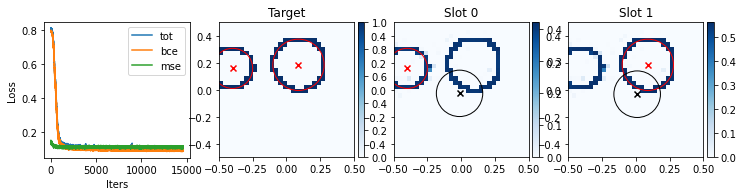

iter 14700 , loss 0.10085985 , lr 0.0002842868472487217


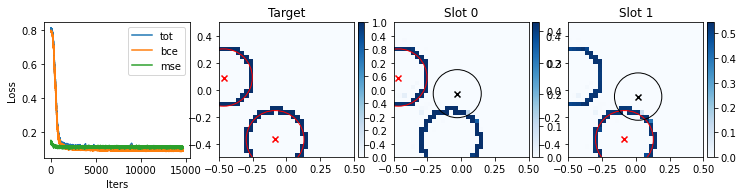

iter 14800 , loss 0.10188399 , lr 0.00028407621362268955


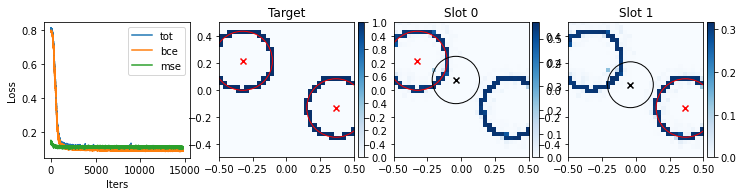

iter 14900 , loss 0.10049147 , lr 0.00028386425671855764


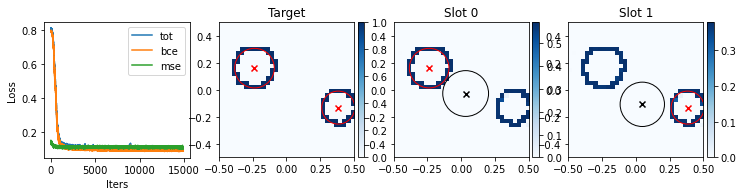

iter 15000 , loss 0.1027436 , lr 0.00028365097862825513


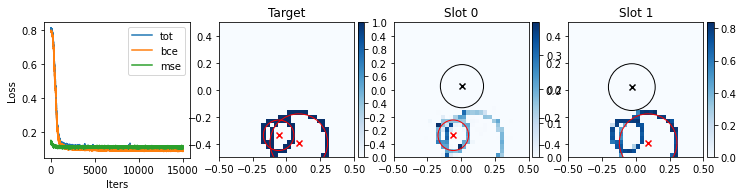

iter 15100 , loss 0.10084375 , lr 0.0002834363814567507


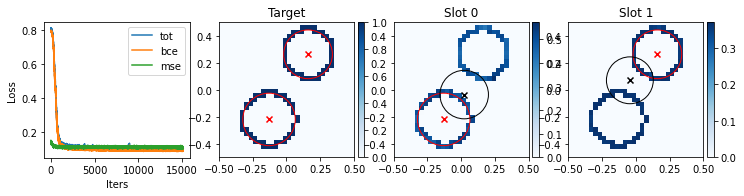

iter 15200 , loss 0.10140042 , lr 0.00028322046732203165


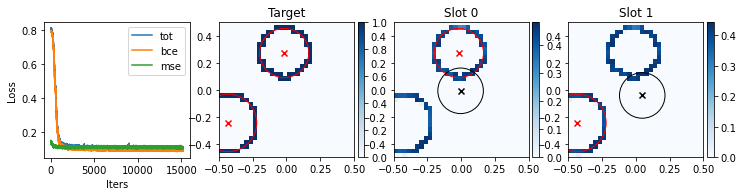

iter 15300 , loss 0.10430082 , lr 0.0002830032383550835


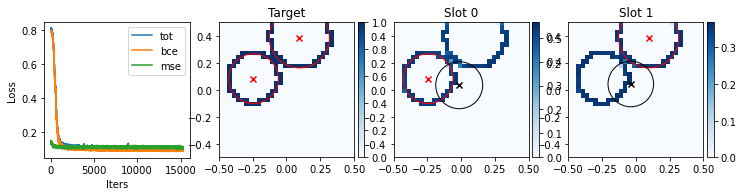

iter 15400 , loss 0.11042726 , lr 0.00028278469669986827


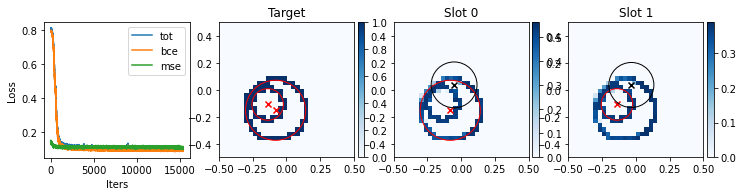

iter 15500 , loss 0.10198135 , lr 0.00028256484451330403


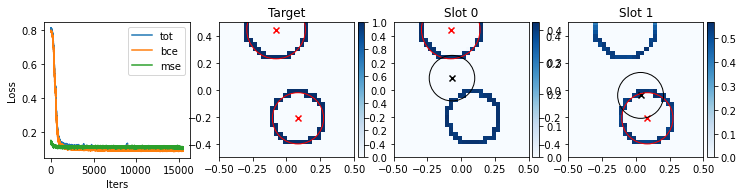

iter 15600 , loss 0.10552596 , lr 0.000282343683965243


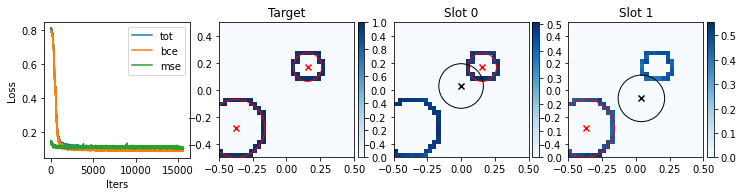

iter 15700 , loss 0.10779985 , lr 0.0002821212172384505


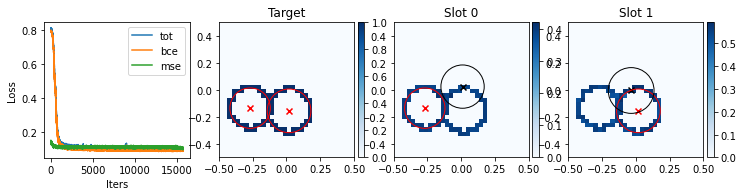

iter 15800 , loss 0.106172085 , lr 0.0002818974465285834


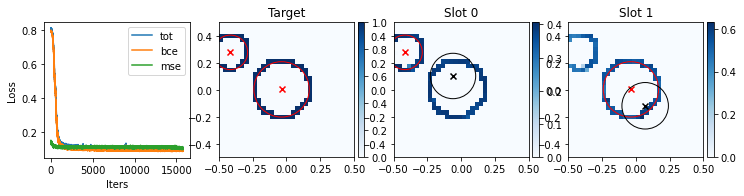

iter 15900 , loss 0.102992095 , lr 0.00028167237404416826


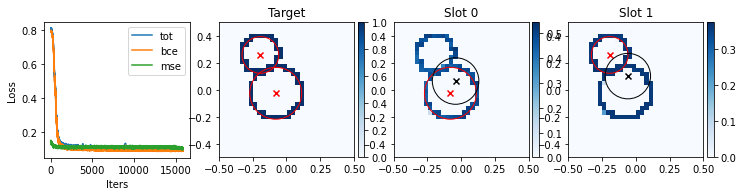

iter 16000 , loss 0.10328078 , lr 0.0002814460020065795


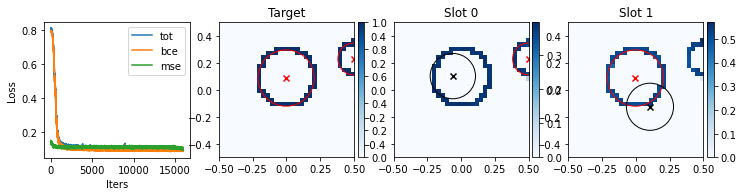

iter 16100 , loss 0.10091477 , lr 0.0002812183326500179


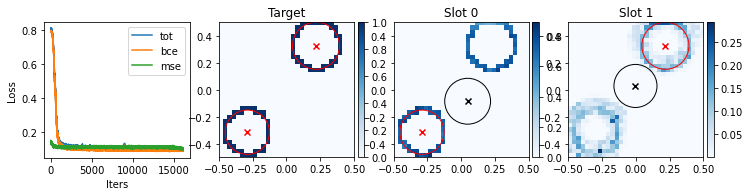

iter 16200 , loss 0.100354075 , lr 0.000280989368221488


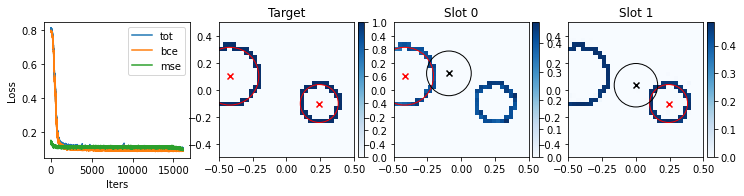

iter 16300 , loss 0.09962456 , lr 0.0002807591109807763


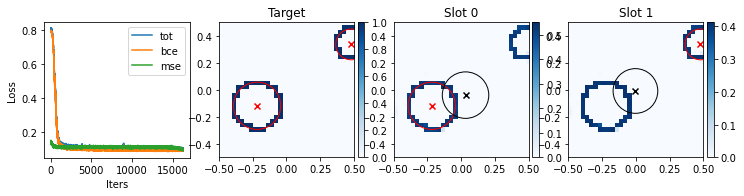

iter 16400 , loss 0.10101478 , lr 0.0002805275632004288


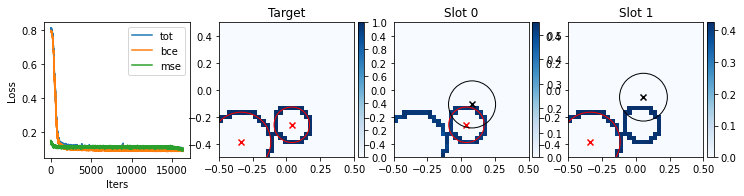

iter 16500 , loss 0.099197805 , lr 0.00028029472716572867


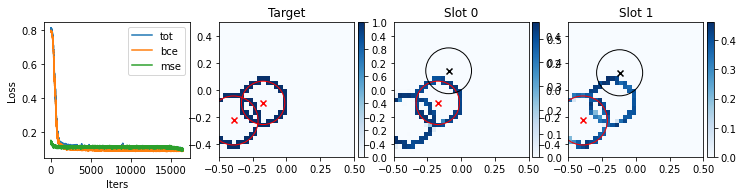

iter 16600 , loss 0.10044114 , lr 0.0002800606051746735


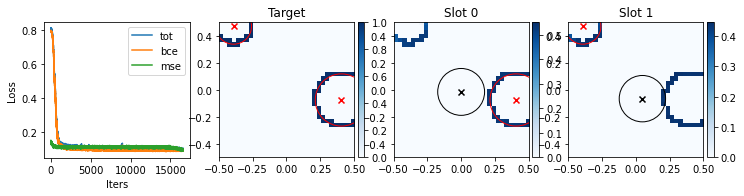

iter 16700 , loss 0.09899741 , lr 0.0002798251995379528


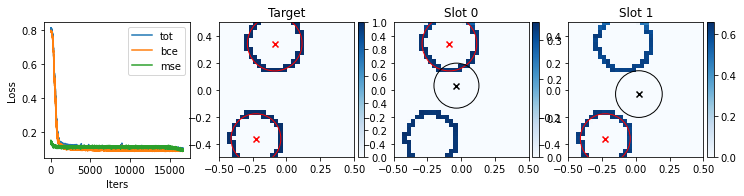

iter 16800 , loss 0.10065934 , lr 0.00027958851257892526


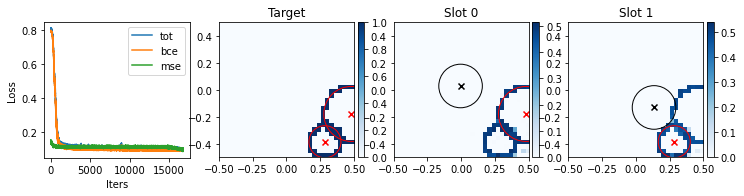

iter 16900 , loss 0.09834633 , lr 0.0002793505466335956


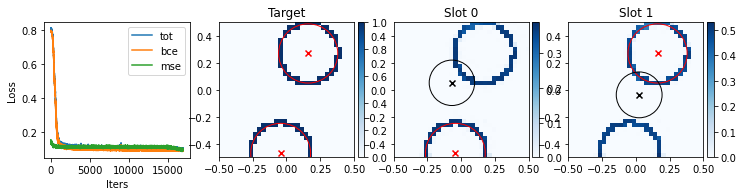

iter 17000 , loss 0.10071431 , lr 0.0002791113040505915


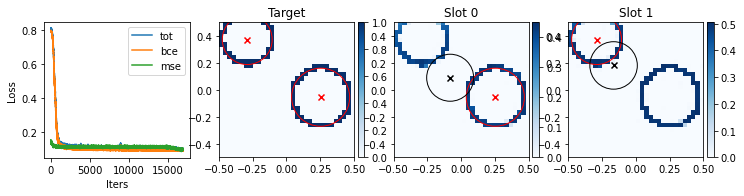

iter 17100 , loss 0.10090837 , lr 0.00027887078719114085


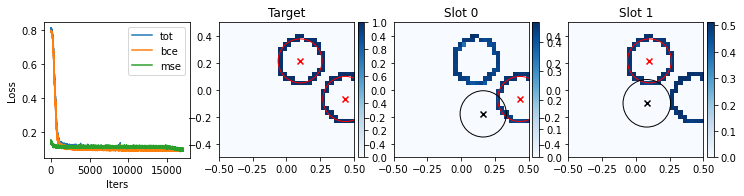

iter 17200 , loss 0.09923826 , lr 0.00027862899842904783


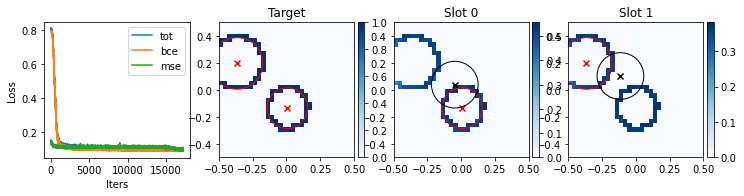

iter 17300 , loss 0.10219575 , lr 0.00027838594015066996


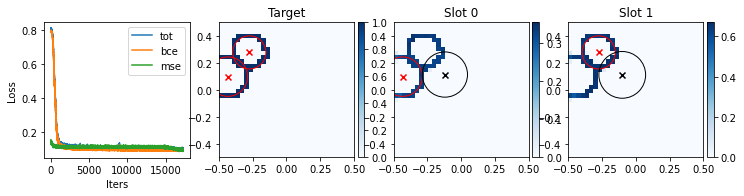

iter 17400 , loss 0.09792504 , lr 0.00027814161475489427


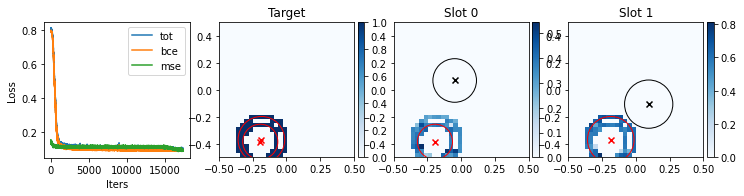

iter 17500 , loss 0.097227424 , lr 0.0002778960246531138


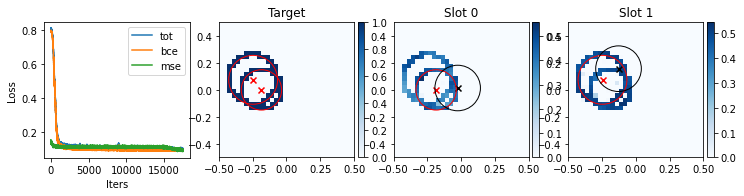

iter 17600 , loss 0.10315601 , lr 0.0002776491722692037


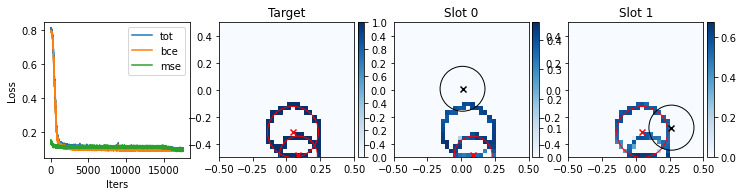

iter 17700 , loss 0.09788365 , lr 0.00027740106003949744


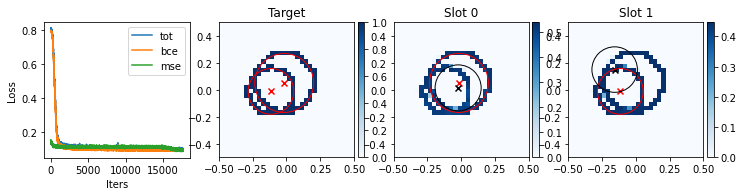

iter 17800 , loss 0.100454085 , lr 0.00027715169041276245


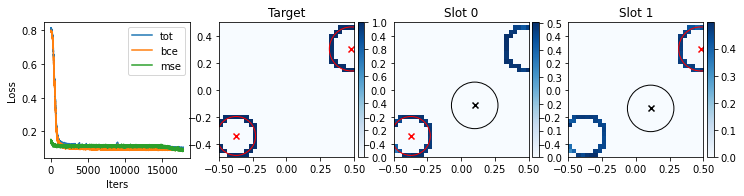

iter 17900 , loss 0.10031032 , lr 0.0002769010658501763


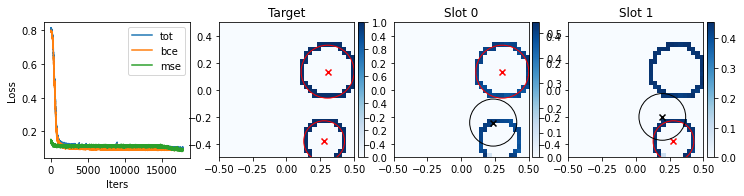

iter 18000 , loss 0.09841889 , lr 0.00027664918882530225


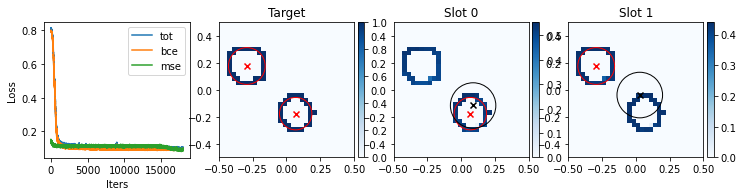

iter 18100 , loss 0.095873185 , lr 0.00027639606182406484


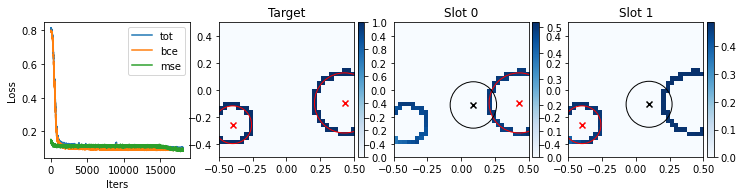

iter 18200 , loss 0.10176678 , lr 0.00027614168734472534


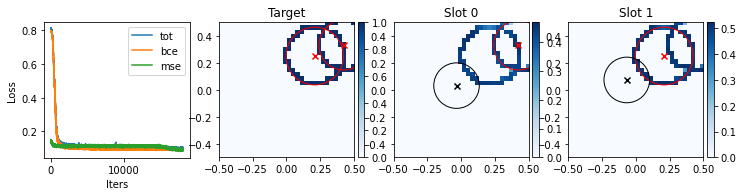

iter 18300 , loss 0.09626063 , lr 0.0002758860678978572


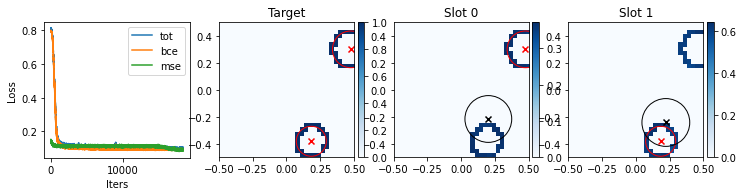

iter 18400 , loss 0.09679428 , lr 0.00027562920600632127


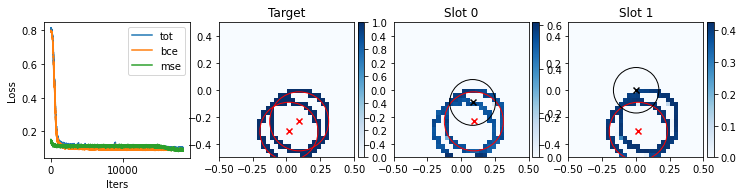

iter 18500 , loss 0.09980936 , lr 0.0002753711042052405


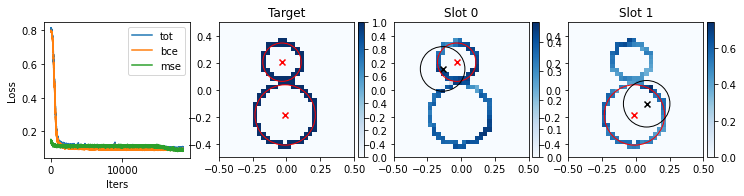

iter 18600 , loss 0.1008641 , lr 0.00027511176504197565


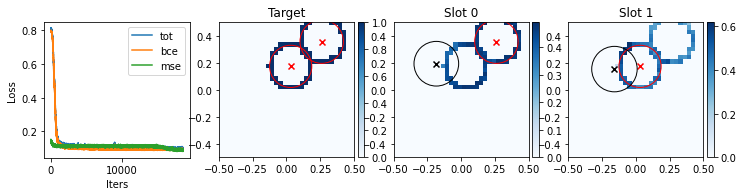

iter 18700 , loss 0.100496285 , lr 0.0002748511910760995


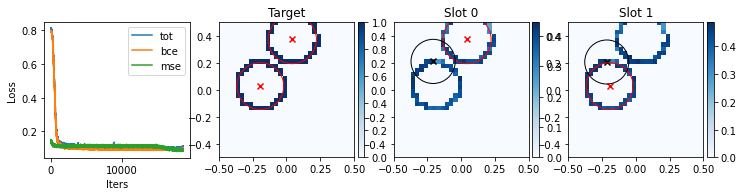

iter 18800 , loss 0.10184833 , lr 0.00027458938487937186


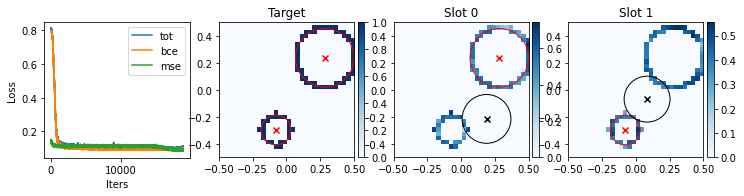

iter 18900 , loss 0.09902891 , lr 0.00027432634903571426


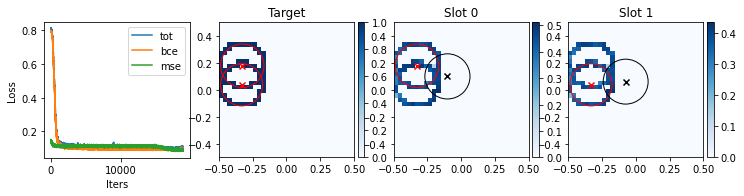

iter 19000 , loss 0.1023925 , lr 0.00027406208614118424


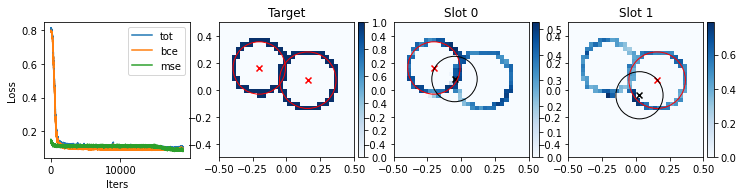

iter 19100 , loss 0.09655225 , lr 0.0002737965988039499


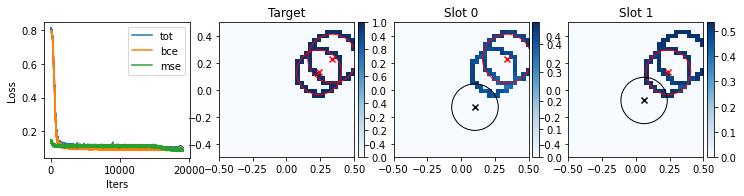

iter 19200 , loss 0.09248802 , lr 0.0002735298896442641


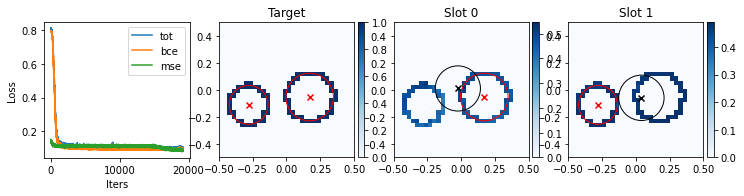

iter 19300 , loss 0.095792875 , lr 0.00027326196129443854


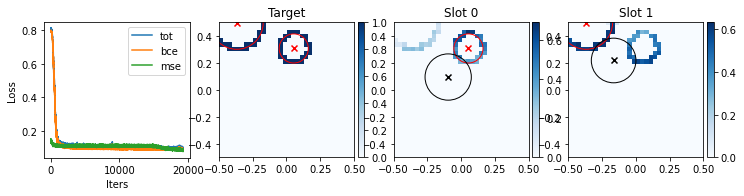

iter 19400 , loss 0.093002446 , lr 0.00027299281639881786


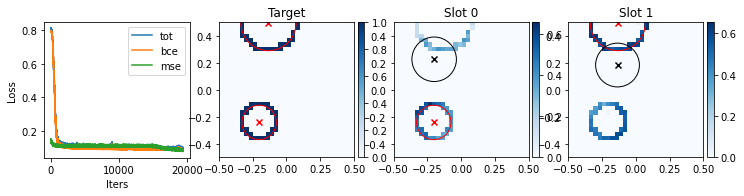

iter 19500 , loss 0.09257329 , lr 0.0002727224576137535


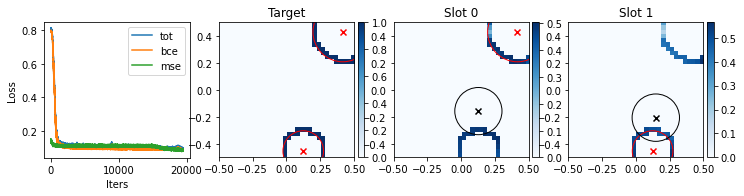

iter 19600 , loss 0.09559862 , lr 0.0002724508876075776


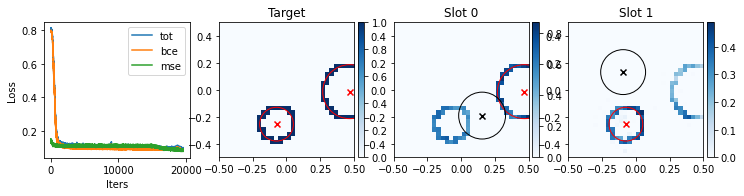

iter 19700 , loss 0.09350764 , lr 0.0002721781090605764


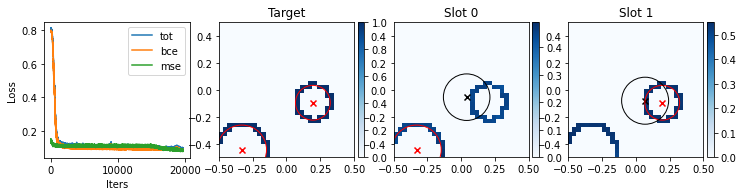

iter 19800 , loss 0.08852478 , lr 0.00027190412466496407


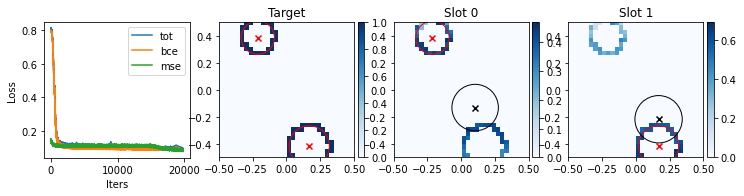

iter 19900 , loss 0.092449725 , lr 0.000271628937124856


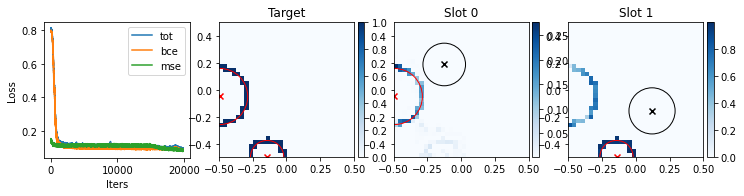

iter 20000 , loss 0.09023964 , lr 0.0002713525491562421


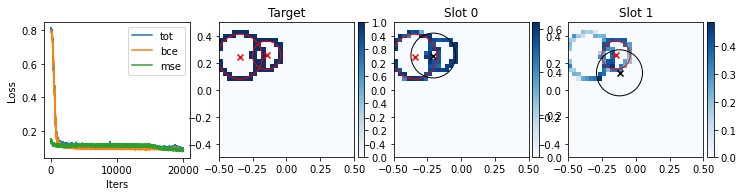

iter 20100 , loss 0.089223124 , lr 0.00027107496348696003


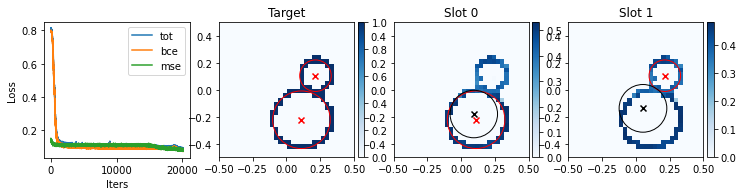

iter 20200 , loss 0.087455116 , lr 0.00027079618285666824


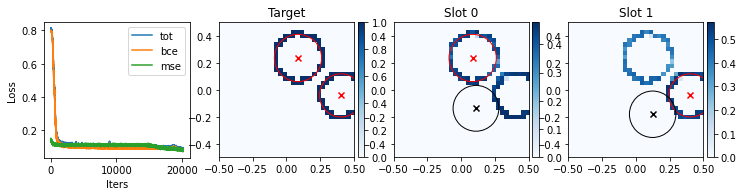

iter 20300 , loss 0.0854583 , lr 0.00027051621001681914


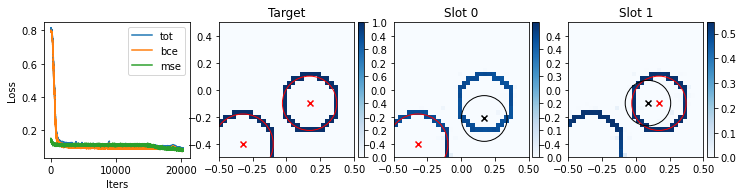

iter 20400 , loss 0.08431308 , lr 0.0002702350477306315


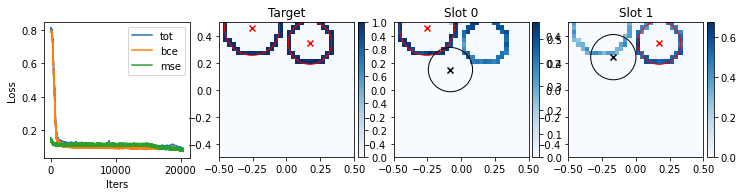

iter 20500 , loss 0.079650626 , lr 0.00026995269877306356


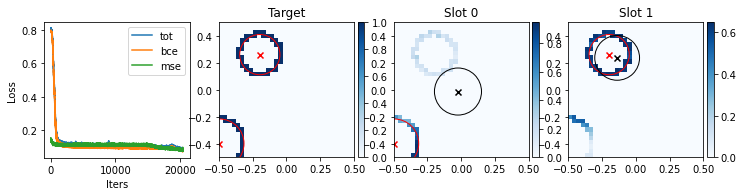

iter 20600 , loss 0.08404573 , lr 0.0002696691659307856


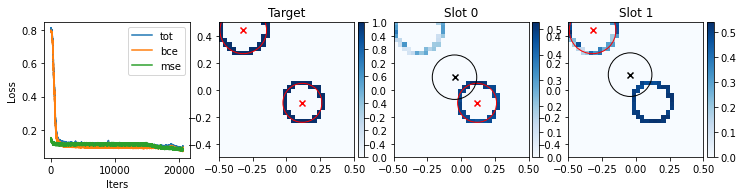

iter 20700 , loss 0.077769585 , lr 0.00026938445200215235


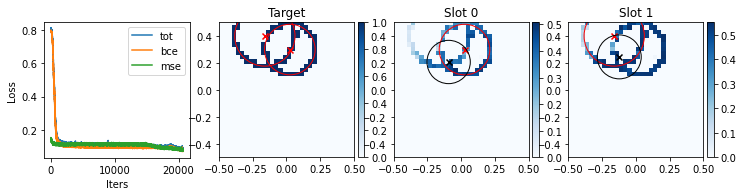

iter 20900 , loss 0.07613042 , lr 0.000268811492137495


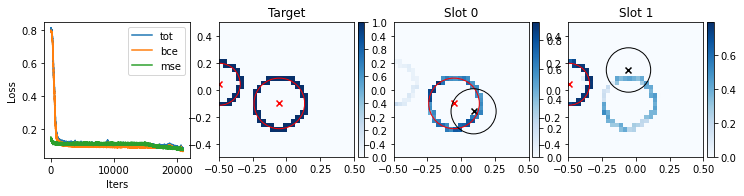

iter 21000 , loss 0.08007203 , lr 0.00026852325185635354


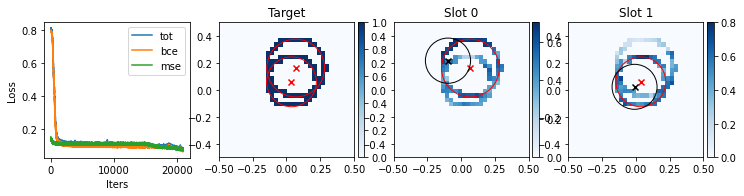

iter 21100 , loss 0.07270519 , lr 0.00026823384179856596


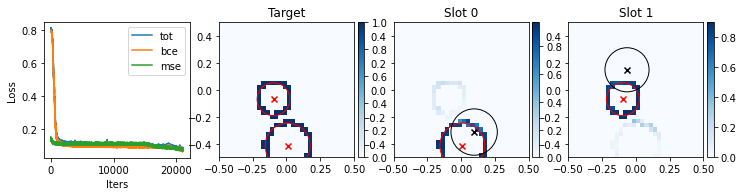

iter 21200 , loss 0.06961314 , lr 0.0002679432648204928


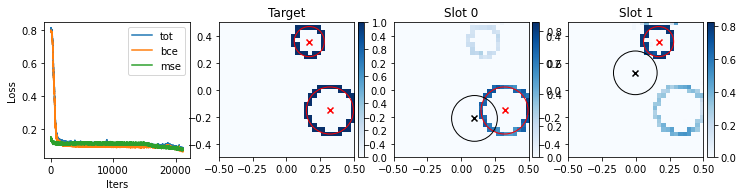

iter 21300 , loss 0.072392255 , lr 0.00026765152379001146


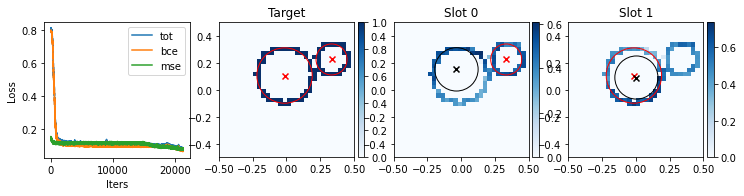

iter 21400 , loss 0.07160682 , lr 0.0002673586215864882


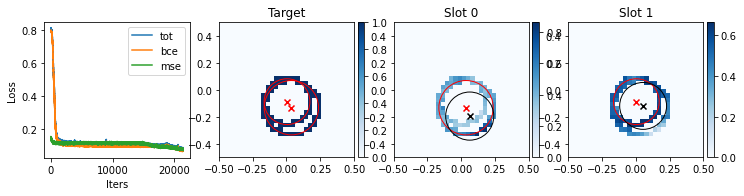

iter 21500 , loss 0.07275983 , lr 0.00026706456110074943


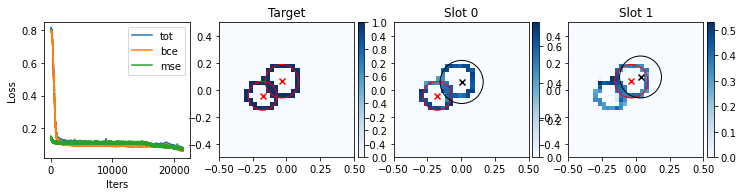

iter 21600 , loss 0.0676906 , lr 0.00026676934523505347


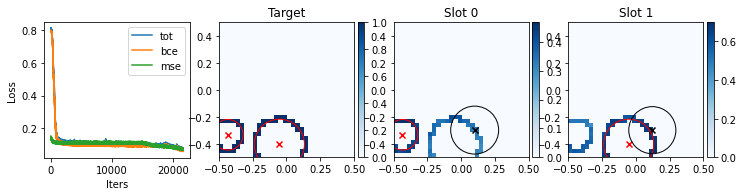

iter 21700 , loss 0.075554684 , lr 0.0002664729769030618


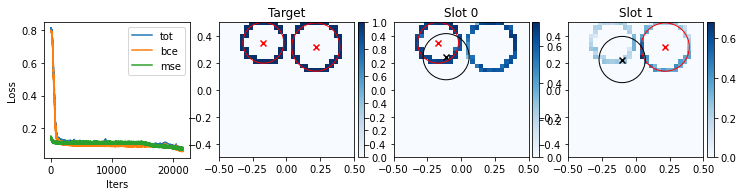

iter 21800 , loss 0.07643828 , lr 0.00026617545902981004


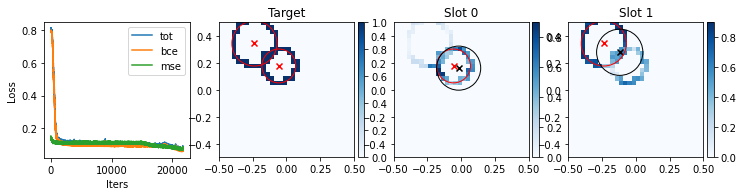

iter 21900 , loss 0.07530242 , lr 0.0002658767945516796


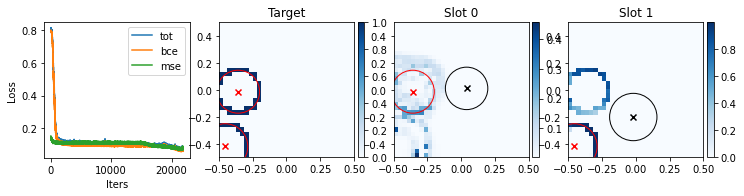

iter 22000 , loss 0.077885315 , lr 0.00026557698641636835


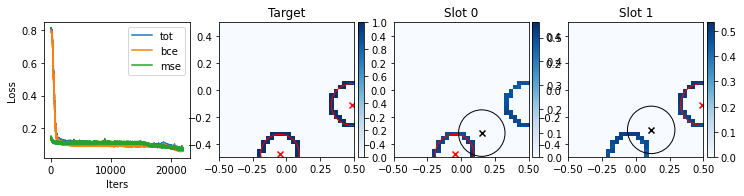

iter 22100 , loss 0.06690732 , lr 0.00026527603758286146


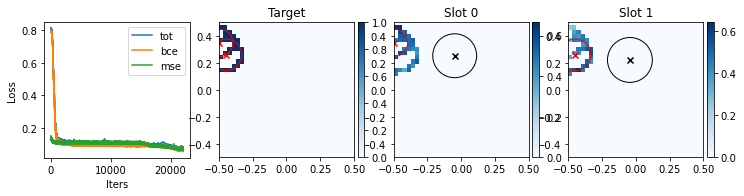

iter 22200 , loss 0.062137038 , lr 0.00026497395102140247


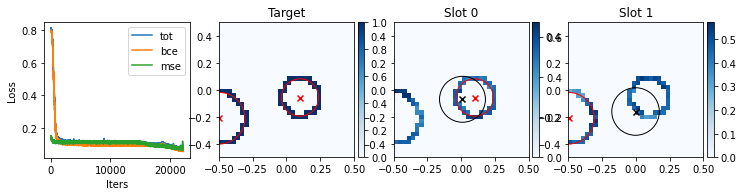

iter 22300 , loss 0.06823652 , lr 0.00026467072971346375


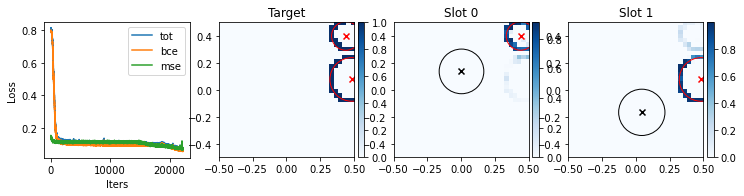

In [ ]:
m,losses = train(m, Ntrain = 100_000, bs=256,  lr=3e-4, warmup_steps=5_000,
                 alpha=.1, device=device,plot_every=100)